# Imports

In [1]:
import sys
# exclude all system paths
sys.path = [
    '/data/projects/c20/sdewin/PhD/papers/CREsted_2025/figure_5',
    '/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python311.zip',
    '/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python3.11',
    '/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python3.11/lib-dynload',
    '/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python3.11/site-packages',
    '/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python3.11/site-packages/setuptools/_vendor',
    '../../'
]

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from nd2reader import ND2Reader
import pims
import matplotlib
import os
import pickle
import anndata
import crested
import pandas as pd
import seaborn as sns
from matplotlib import cm as mpl_cm
import matplotlib as mpl
import logomaker
import modiscolite
import torch
from tangermeme.tools.tomtom import tomtom
from scipy.spatial import distance
from scipy.cluster import hierarchy
import pyranges as pr

2025-02-24 08:29:01.575622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 08:29:02.605687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740382143.069625  575350 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740382143.178007  575350 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 08:29:04.195012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Set-up

In [3]:
IM_FOLDER="/data/projects/c20/sdewin/PhD/zebrafish_imaging"

In [4]:
green_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(   "green",   [(0, 0, 0, 0), (0, 1, 0, 1)])
red_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(     "red",     [(0, 0, 0, 0), (1, 0, 0, 1)])
blue_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(    "blue",    [(0, 0, 0, 0), (0, 0, 1, 1)])
white_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(   "white",   [(0, 0, 0, 0), (1, 1, 1, 1)])
white_cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list( "white",   [(1, 1, 1, 1), (0, 0, 0, 0)])

In [4]:
%matplotlib inline

# Read data

In [5]:
adata = anndata.read_h5ad("data_prep/data/zebrafish_anndata.h5ad")

In [7]:
with open("data_prep/synthetic_enhancers/ISE_Slow_muscle_cell_0_Slow_muscle_cells_0_Fast_muscle_cells_0_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl", "rb") as f:
    cardiac_target = pickle.load(f)
    cardiac_metadata = pickle.load(f)
    cardiac_designed = pickle.load(f)

with open("data_prep/synthetic_enhancers/ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.pkl", "rb") as f:
    body_target = pickle.load(f)
    body_metadata = pickle.load(f)
    body_designed = pickle.load(f)

with open("data_prep/synthetic_enhancers/ISE_hpf72_Endothelial.pkl", "rb") as f:
    endo_target = pickle.load(f)
    endo_metadata = pickle.load(f)
    endo_designed = pickle.load(f)

In [8]:
to_short = {
    "ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl": "ISE_mus_body_0.5_cardiac_1" ,
    "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5.pkl": "ISE_mus_body_1_cardiac_0.5",
    "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl": "ISE_mus_body_1_cardiac_1",
    "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.pkl": "ISE_mus_body_1_cardiac_0",
    "ISE_Slow_muscle_cell_0_Slow_muscle_cells_0_Fast_muscle_cells_0_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl": "ISE_mus_body_0_cardiac_1",
}

In [9]:
to_super_short = {
    "ISE_mus_body_0.5_cardiac_1": "0.5/1.0",
    "ISE_mus_body_1_cardiac_0.5": "1.0/0.5",
    "ISE_mus_body_1_cardiac_1": "1.0/1.0"
}

In [10]:
dual_target = {}
dual_metadata = {}
dual_designed = {}
for k in [
    "ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl",
    "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5.pkl",
    "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl"
]:
    print(k)
    with open(f"data_prep/synthetic_enhancers/{k}", "rb") as f:
        dual_target[to_short[k]] = pickle.load(f)
        dual_metadata[to_short[k]] = pickle.load(f)
        dual_designed[to_short[k]] = pickle.load(f)

ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl
ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5.pkl
ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1.pkl


In [11]:
enhancer_to_name = {
    "ISE_hpf72_Endothelial__4":	"A1",
    "ISE_mus_body_1_cardiac_1__123":	"A2",
    "ISE_mus_body_0.5_cardiac_1__185":	"A3",
    "ISE_hpf72_Endothelial__99":	"B1",
    "ISE_mus_body_1_cardiac_0__183":	"B2",
    "ISE_mus_body_0.5_cardiac_1__91":	"B3",
    "ISE_hpf72_Endothelial__76":	"C1",
    "ISE_mus_body_1_cardiac_0__22":	"C2",
    "ISE_mus_body_1_cardiac_0.5__126":	"D1",
    "ISE_mus_body_1_cardiac_0__141":	"D2",
    "ISE_mus_body_1_cardiac_0.5__32":	"E1",
    "ISE_mus_body_0_cardiac_1__174":	"E2",
    "ISE_mus_body_1_cardiac_0.5__4":	"F1",	
    "ISE_mus_body_0_cardiac_1__23":	"F2",
    "ISE_mus_body_1_cardiac_1__109":	"G1",
    "ISE_mus_body_0_cardiac_1__113":	"G2",
    "ISE_mus_body_1_cardiac_1__127":	"H1",
    "ISE_mus_body_0.5_cardiac_1__121":	"H2"
}

In [12]:
tested_enhancers_cardiac = []
tested_enhancers_body = []
tested_enhancers_endo = []
tested_enhancers_body_cardiac = {}
tested_enhancers_cardiac_names = []
tested_enhancers_body_names = []
tested_enhancers_endo_names = []
tested_enhancers_body_cardiac_names = {}
with open("data_prep/synthetic_enhancers/cardiac_body_endothelial_enhancers_w_adaptors_short_name.fa", "rt") as f:
    for l in f:
        if not l.startswith(">"):
            continue
        match l.split("__")[0]:
            case ">ISE_mus_body_0_cardiac_1":
                _list = tested_enhancers_cardiac
                _list_n = tested_enhancers_cardiac_names
            case ">ISE_mus_body_1_cardiac_0":
                _list = tested_enhancers_body
                _list_n = tested_enhancers_body_names
            case ">ISE_hpf72_Endothelial":
                _list = tested_enhancers_endo
                _list_n = tested_enhancers_endo_names
            case _:
                name = l.split("__")[0].replace(">", "")
                if name not in tested_enhancers_body_cardiac:
                    tested_enhancers_body_cardiac[name] = []
                    tested_enhancers_body_cardiac_names[name] = []
                tested_enhancers_body_cardiac[name].append(int(l.split("__")[1].strip()))
                tested_enhancers_body_cardiac_names[name].append(enhancer_to_name[l.strip().replace(">", "")])
                continue
        _list.append(int(l.split("__")[1].strip()))
        _list_n.append(enhancer_to_name[l.strip().replace(">", "")])

In [ ]:
adata = anndata.read_h5ad("data_prep/data/zebrafish_anndata.h5ad")

genome = crested.Genome(
    fasta="/data/projects/c20/sdewin/resources/danRer11/danRer11.fa",
    chrom_sizes="/data/projects/c20/sdewin/resources/danRer11/danRer11.chrom.sizes",
)

data_module = crested.tl.data.AnnDataModule(
  adata,
  genome
)

model = crested.tl.Crested(data = data_module)

model.load_model(
  "data_prep/model/03.keras"
)

enhancer_val_dir = "data_prep/validation_data/"

validated_enhancer_regions = pd.read_table(
  os.path.join(enhancer_val_dir, "tested_enhancers.bed"),
  header = None, names = ["chrom", "start", "end", "name"]
)

validated_enhancer_metadata = pd.read_table(
  os.path.join(enhancer_val_dir, "metadata.tsv")
)

validated_enhancer_regions["mid"] = (
  validated_enhancer_regions["start"] + ((validated_enhancer_regions["end"] - validated_enhancer_regions["start"]) / 2)
).astype(int)

size = 2114
validated_enhancer_regions["new_start"] = validated_enhancer_regions["mid"] - size // 2
validated_enhancer_regions["new_end"]   = validated_enhancer_regions["mid"] + size // 2

validated_enhancer_region_names = (
  validated_enhancer_regions.chrom + ":" \
    + validated_enhancer_regions.new_start.astype(str) + "-" \
    + validated_enhancer_regions.new_end.astype(str)
).to_list()

validated_enhancer_prediction_scores = model.predict_regions(validated_enhancer_region_names)

timepoint = "hpf48"
time_point_idc = [i for i, x in enumerate(adata.obs_names) if x.split(":")[0] == timepoint]

selected_cell_types = [
    "hpf48:Diencephalon", #
    "hpf48:Endothelial",
    "hpf48:Erythroid",
    "hpf48:Fast muscle cells",
    "hpf48:Gut",
    "hpf48:Hindbrain dorsal",
    "hpf48:Hindbrain ventral",
    "hpf48:Lens",
    "hpf48:Midbrain",
    "hpf48:Midbrain ventral",
    "hpf48:Myoblast",
    "hpf48:Neural crest",
    "hpf48:Notochord",
    "hpf48:Olfactory placode",
    "hpf48:Otic placode",
    "hpf48:Slow muscle cells",
    "hpf48:Telencephalon",
    "hpf48:Roofplate"
]

selected_idc = [i for i, x in enumerate(adata.obs_names) if x in selected_cell_types]

validated_enhancer_metadata["frac_pos"] = [
  eval(x) for x in validated_enhancer_metadata["positive ratio"]
]

In [16]:
len(validated_enhancer_metadata["tissue"].dropna().sort_values().index)

54

In [19]:
data = validated_enhancer_prediction_scores[validated_enhancer_metadata["tissue"].dropna().sort_values().index, :][:, selected_idc].T

In [36]:
n_correct = 0
for cla, enh in zip(adata.obs_names[np.array(selected_idc)[data.argmax(0)]], validated_enhancer_metadata["tissue"].dropna().sort_values()):
    c = input(f"{cla}\t{enh}")
    if c == "y":
        n_correct += 1

hpf48:Endothelial	blood vessel y
hpf48:Endothelial	blood vessel y
hpf48:Endothelial	blood vessel y
hpf48:Endothelial	blood vessel y
hpf48:Hindbrain ventral	brain y
hpf48:Midbrain	brain y
hpf48:Lens	endoderm n
hpf48:Erythroid	erythrocyte y
hpf48:Lens	eye y
hpf48:Gut	gut y
hpf48:Gut	heart n
hpf48:Slow muscle cells	heart n
hpf48:Erythroid	heart n
hpf48:Slow muscle cells	heart n
hpf48:Myoblast	intestine n
hpf48:Myoblast	muscle y
hpf48:Myoblast	muscle y
hpf48:Myoblast	muscle y
hpf48:Fast muscle cells	muscle y
hpf48:Slow muscle cells	muscle y
hpf48:Endothelial	muscle n
hpf48:Myoblast	muscle y
hpf48:Slow muscle cells	muscle y
hpf48:Myoblast	muscle y
hpf48:Notochord	muscle n
hpf48:Neural crest	neural crest y
hpf48:Neural crest	neural crest y
hpf48:Diencephalon	neuron y
hpf48:Hindbrain ventral	neuron y
hpf48:Hindbrain ventral	neuron y
hpf48:Diencephalon	neuron y
hpf48:Telencephalon	neuron y
hpf48:Telencephalon	neuron y
hpf48:Midbrain ventral	neuron y
hpf48:Myoblast	neuron(head) n
hpf48:Hindbrai

In [39]:
(n_correct / len(validated_enhancer_metadata["tissue"].dropna().sort_values().index)) * 100

75.92592592592592

In [27]:
validated_enhancer_metadata["tissue"].dropna().sort_values()

5          blood vessel
14         blood vessel
16         blood vessel
17         blood vessel
64                brain
11                brain
39             endoderm
46          erythrocyte
8                   eye
49                  gut
38                heart
24                heart
40                heart
20                heart
25            intestine
27               muscle
29               muscle
30               muscle
2                muscle
22               muscle
19               muscle
13               muscle
3                muscle
26               muscle
18               muscle
96         neural crest
98         neural crest
94               neuron
92               neuron
91               neuron
65               neuron
66               neuron
68               neuron
74               neuron
84         neuron(head)
83         neuron(head)
78        neuron(trunk)
86        neuron(trunk)
82        neuron(trunk)
80        neuron(trunk)
79        neuron(trunk)
7             no

In [15]:
def plot_enhancer_pred_heatmap(axs: list[plt.Axes]):
    abbr = {
        'blood vessel': "b.v.",
        'brain': "brn.",
        'endoderm': "endo.",
        'erythrocyte': "eryth.",
        'eye': "eye",
        'gut': "gut",
        'heart': "hrt.",
        'intestine': "intest.",
        'muscle': "mus.",
        'neural crest': "n.c.",
        'neuron': "neu.",
        'neuron(head)': "neu. h.",
        'neuron(trunk)': "neu. t.",
        'notochord': "noto.",
        'olfactory bulb': "olf. b.",
        'olfactory placode': "olf. p.",
        'optic': "opt.",
        'otic': "ot.",
        'roofplate': "r.p."
    }
    norm = mpl.colors.Normalize(vmin = 0, vmax = 1)
    cmap = mpl_cm.binary_r
    m = mpl_cm.ScalarMappable(norm=norm, cmap=cmap)
    
    col_colors = [
      m.to_rgba(x) for x in validated_enhancer_metadata \
      .dropna(subset = "tissue").sort_values("tissue")["frac_pos"]
    ]
    
    data = validated_enhancer_prediction_scores[validated_enhancer_metadata["tissue"].dropna().sort_values().index, :][:, selected_idc].T
    selected_idc_sorted = []
    for i in data.argmax(0):
        if i in selected_idc_sorted:
            continue
        selected_idc_sorted.append(i)
    
    sns.heatmap(
        data[selected_idc_sorted],
        ax = axs[1],
        xticklabels = [abbr[x] for x in validated_enhancer_metadata["tissue"].dropna().sort_values().values],
        yticklabels = adata.obs_names[selected_idc][selected_idc_sorted],
        robust = True,
        cmap = "inferno",
        cbar_kws={"shrink": 0.2},
        cbar= False,
        vmin = 0, vmax = 25
    )
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 45, ha = "right")
    axs[0].imshow(np.array(col_colors)[None], zorder = 1)
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    return axs

In [16]:
def plot_boxplot_pred_scores(ax: plt.Axes, class_idx: int, synth_metadata: dict, to_highlight: list[int], highlight_names = list[str]):
    n_mut = 30
    n_seq = 200
    pred_scores = np.empty( (n_seq, n_mut + 1) )
    pred_scores_hg = np.empty( (len(to_highlight), n_mut + 1) )
    for i in range(n_seq):
        for j in range(n_mut + 1):
            pred_scores[i, j] = synth_metadata[i]["predictions"][j][0, class_idx] \
                if len(synth_metadata[i]["predictions"][j].shape) == 2 \
                else synth_metadata[i]["predictions"][j][class_idx]
            if i in to_highlight:
                pred_scores_hg[to_highlight.index(i), j] = pred_scores[i, j]
    ax.boxplot(
        pred_scores[:, [0, *[i * 2 + 2 for i in range(n_mut  // 2)] ] ],
        widths = 0.5,
        showfliers = False,
        notch = True,
        boxprops = dict(color = "#2674ad", lw = 0.5),
        capprops = dict(color = "#2674ad", lw = 0.5),
        whiskerprops = dict(color = "#2674ad", lw = 0.5),
        medianprops = dict(color = "#2674ad", lw = 0.5)
    ) 
    for i in range(len(to_highlight)):
        ax.plot(
            np.arange(n_mut // 2 + 1) + 1,
            pred_scores_hg[i, [0, *[i * 2 + 2 for i in range(n_mut  // 2)] ] ],
            label = highlight_names[i],
            lw = 0.8,
            color = plt.cm.Set2(i)
        )
    ax.set_xticklabels([ i if i == 0 or i == n_mut else "" for i in [0, *[i * 2 + 2 for i in range(n_mut  // 2)] ] ])
    ax.legend(loc = "upper center", bbox_to_anchor=(0.5, -0.05), ncols = 3, frameon = False, fontsize = 3, labelspacing = 0.2)
    return ax

In [17]:
def plot_dual(ax):
    enhancer_names_to_colors = {
        'ISE_mus_body_1_cardiac_0.5': ["#ff7500", "#FF715B", "#b14f41"],
        'ISE_mus_body_1_cardiac_1': ["#1ef9df", "#1EA896", "#167468"],
        'ISE_mus_body_0.5_cardiac_1': ["#32c7ff", "#247BA0", "#164b62"]
    }
    for k in tested_enhancers_body_cardiac.keys():
        for i in range(3):
            preds = dual_metadata[k][tested_enhancers_body_cardiac[k][i]]["predictions"]
            preds_c = [ p.squeeze()[np.where(adata.obs_names == "hpf48:Cardiac muscle")[0][0] ] for p in preds ]
            preds_b = [ p.squeeze()[np.where(adata.obs_names == "hpf48:Fast muscle cells")[0][0] ] for p in preds ]
            x = np.array(preds_c)
            y = np.array(preds_b)
            ax.quiver(
                x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
                scale_units='xy', angles='xy', scale=1, color = enhancer_names_to_colors[k][i],
                label = enhancer_to_name[k + "__" + str(tested_enhancers_body_cardiac[k][i])]
            )
    
    ax.legend(loc = "upper center", bbox_to_anchor=(0.5, -0.05), ncols = 3, frameon = False, fontsize = 3, labelspacing = 0.2)
    ax.set_xlabel("Cardiac mus. prediction score")
    ax.set_ylabel("Body mus. prediction score")
    ax.grid()
    return ax

In [18]:
def plot_boxplot_pred_scores_dual(ax, class_idx):
    enhancer_names_to_colors = {
        'ISE_mus_body_1_cardiac_0.5': ["#ff7500", "#FF715B", "#b14f41"],
        'ISE_mus_body_1_cardiac_1': ["#1ef9df", "#1EA896", "#167468"],
        'ISE_mus_body_0.5_cardiac_1': ["#32c7ff", "#247BA0", "#164b62"]
    }
    
    dat = np.array([
            np.array([dual_metadata[k][s]["predictions"][-1] for s in range(len(dual_metadata[k]))])[:, class_idx]
            for k in dual_metadata.keys()
        ]
    )
    
    
    bplot = ax.boxplot(
        dat.T,
        patch_artist=True,
        notch = True,
        showfliers = False,
        labels = [to_super_short[x] for x in dual_metadata.keys()]
    )
    
    for box, median, n in zip(bplot["boxes"],  bplot["medians"], dual_metadata.keys()):
        box.set_edgecolor(enhancer_names_to_colors[n][1])
        box.set_facecolor("none")
        median.set_color(enhancer_names_to_colors[n][1])
    
    for whisker, cap, n in zip(bplot["whiskers"], bplot["caps"], np.repeat(list(dual_metadata.keys()), 2)):
        whisker.set_color(enhancer_names_to_colors[n][1])
        cap.set_color(enhancer_names_to_colors[n][1])
    return ax


In [19]:
def plot_image(ax, path_to_image_bright, path_to_image_gfp, embryo_index, green_vmin, green_vmax, y_cut_top, embryos_to_keep):
    image_bright = ND2Reader(path_to_image_bright)[0]
    images = ND2Reader(path_to_image_gfp)
    print(images.sizes)
    images.bundle_axes = "zyx"
    image_c1 = images[0]
    image_c1_max = image_c1.max(0)
    embryo_x_start, embryo_x_end = embryos_to_keep[embryo_index]
    embryo_c_1 = np.asarray(image_c1_max.transpose().data[embryo_x_start: embryo_x_end]).T
    embryo_bright = np.asarray(image_bright.transpose().data[embryo_x_start: embryo_x_end]).T
    y_cut_bot = 1500 - y_cut_top
    ax.imshow(embryo_bright[y_cut_top:embryo_c_1.shape[0] - y_cut_bot], cmap = plt.cm.gray)
    ax.imshow(embryo_c_1[y_cut_top:embryo_c_1.shape[0] - y_cut_bot], cmap = green_cmap, vmin = green_vmin, vmax = green_vmax)
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    return ax

In [20]:
def plot_image_1(ax, path_to_image_gfp, embryo_index, green_vmin, green_vmax, y_cut_top, embryos_to_keep):
    images = ND2Reader(path_to_image_gfp)
    print(images.sizes)
    images.bundle_axes = "zyx"
    images.iter_axes = "c"
    image_bright = images[2]
    image_bright = image_bright[images.shape[1] // 2] # middle z
    image_c1 = images[0]
    image_c1_max = image_c1.max(0)
    embryo_x_start, embryo_x_end = embryos_to_keep[embryo_index]
    embryo_c_1 = np.asarray(image_c1_max.transpose().data[embryo_x_start: embryo_x_end]).T
    embryo_bright = np.asarray(image_bright.transpose().data[embryo_x_start: embryo_x_end]).T
    y_cut_bot = 1500 - y_cut_top
    ax.imshow(embryo_bright[y_cut_top:embryo_c_1.shape[0] - y_cut_bot], cmap = plt.cm.gray)
    ax.imshow(embryo_c_1[y_cut_top:embryo_c_1.shape[0] - y_cut_bot], cmap = green_cmap, vmin = green_vmin, vmax = green_vmax)
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    return ax

In [21]:
def plot_image_2(ax, path_to_image_gfp, path_to_image_bright, green_vmin, green_vmax, y_cut_top):
    image_bright = ND2Reader(path_to_image_bright)[0]
    images = ND2Reader(path_to_image_gfp)
    images.bundle_axes = "zyx"
    print(images.sizes)
    embryo_bright = image_bright
    embryo_c_1 = images[0].max(0)
    ax.imshow(embryo_bright, cmap = plt.cm.gray)
    ax.imshow(embryo_c_1, cmap = green_cmap, vmin = green_vmin, vmax = green_vmax)
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    return ax

In [22]:
def plot_image_t(ax, path_to_image_gfp, path_to_image_bright, green_vmin, green_vmax, y_cut_top):
    image_bright = ND2Reader(path_to_image_bright)[0]
    images = ND2Reader(path_to_image_gfp)
    images.iter_axes = "t"
    print(images.sizes)
    embryo_bright = image_bright
    embryo_c_1 = np.array([im for im in images]).max(0)
    ax.imshow(embryo_bright, cmap = plt.cm.gray)
    ax.imshow(embryo_c_1, cmap = green_cmap, vmin = green_vmin, vmax = green_vmax)
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    return ax

In [23]:
def plot_image_t_2(ax, path_to_image_gfp, green_vmin, green_vmax, y_cut_top):
    images = ND2Reader(path_to_image_gfp)
    images.iter_axes = "t"
    print(images.sizes)
    embryo_c_1 = np.array([im for im in images]).max(0)
    ax.imshow(embryo_c_1, cmap = green_cmap, vmin = green_vmin, vmax = green_vmax)
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [24]:
def plot_attr(ax: plt.Axes, selected_enhancer: int, path: str, zoom: slice):
    attr = np.load(path + "_contrib.npz")["arr_0"][selected_enhancer]
    oh = np.load(path + "_oh.npz")["arr_0"][selected_enhancer]
    
    _ = logomaker.Logo(
        pd.DataFrame(
            (attr * oh).T[zoom],
            columns = ["A", "C", "G", "T"]
        ),
        ax = ax
    )
    
    mag = (attr * oh).T.sum(1)
    init_seq = cardiac_metadata[selected_enhancer]["inital_sequence"]
    return ax

In [25]:
def plot_attr_dual(ax1: plt.Axes, selected_enhancer: int, path_car: str, path_bod, zoom: slice):

    ax2 = ax1.twinx()
    
    ax1.tick_params(axis='y', labelcolor="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:blue")
    
    
    attr_car = np.load(path_car + "_contrib.npz")["arr_0"][selected_enhancer]
    attr_bod = np.load(path_bod + "_contrib.npz")["arr_0"][selected_enhancer]
    oh = np.load(path_car + "_oh.npz")["arr_0"][selected_enhancer]
    
    _ = logomaker.Logo(
        pd.DataFrame(
            (attr_car * oh).T[zoom],
            columns = ["A", "C", "G", "T"]
        ),
        ax = ax1,
        color_scheme = "tab:red",
        alpha = 0.8
    )
    
    _ = logomaker.Logo(
        pd.DataFrame(
            (attr_bod * oh).T[zoom],
            columns = ["A", "C", "G", "T"]
        ),
        ax = ax2,
        color_scheme = "tab:blue",
        alpha = 0.8
    )
    
    ax_1_ymin, ax_1_ymax = ax1.get_ylim()
    ax_2_ymin, ax_2_ymax = ax2.get_ylim()
    
    ratio = max(abs(ax_1_ymin/ax_1_ymax), abs(ax_2_ymin/ax_2_ymax))
    
    ax1.set_ylim(-ax_1_ymax * ratio, ax_1_ymax)
    ax1.set_ylim(-ax_2_ymax * ratio, ax_2_ymax)

    return ax1, ax2

# old pattern heatmap

For the paper we used another figure, please refer to `crested_heatmap.ipynb`

Reading file data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1/hpf72:Cardiac muscle_modisco_results.h5
Reading file data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5/hpf72:Cardiac muscle_modisco_results.h5
Reading file data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0/hpf72:Cardiac muscle_modisco_results.h5
Reading file data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1/hpf72:Cardiac muscle_modisco_results.h5
Reading file data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/ISE_Slow_muscle_cell_0_Slow_muscle_cells_0_Fast_muscle_cell

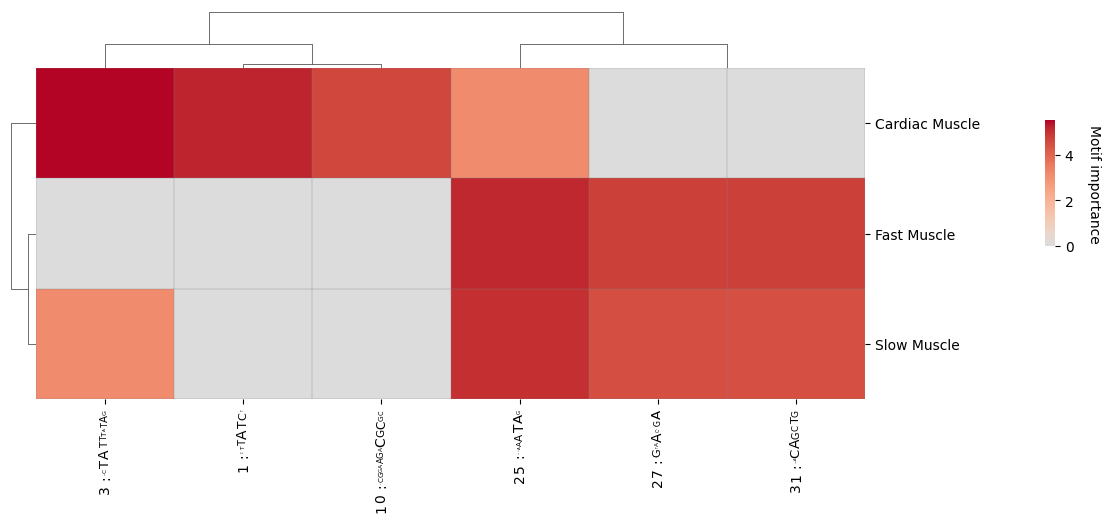

In [378]:
modisco_dir = "data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/"

matched_files = {
    "Cardiac Muscle": [
        os.path.join(modisco_dir, s, "hpf72:Cardiac muscle_modisco_results.h5")
        for s in os.listdir(modisco_dir)
    ],
    "Fast Muscle": [
        os.path.join(modisco_dir, s, "hpf72:Fast muscle cells_modisco_results.h5")
        for s in os.listdir(modisco_dir)
    ],
    "Slow Muscle": [
        os.path.join(modisco_dir, s, "hpf72:Slow muscle cells_modisco_results.h5")
        for s in os.listdir(modisco_dir)
    ],
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files=matched_files,
    sim_threshold=6,
    trim_ic_threshold=0.15,
    discard_ic_threshold=0.1,
    verbose=True
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
pat_seqs = crested.tl.modisco.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.clustermap(
    pattern_matrix,
    list(matched_files.keys()),
    figsize=(10, 4.2),
    pat_seqs=pat_seqs,
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=4.5
)

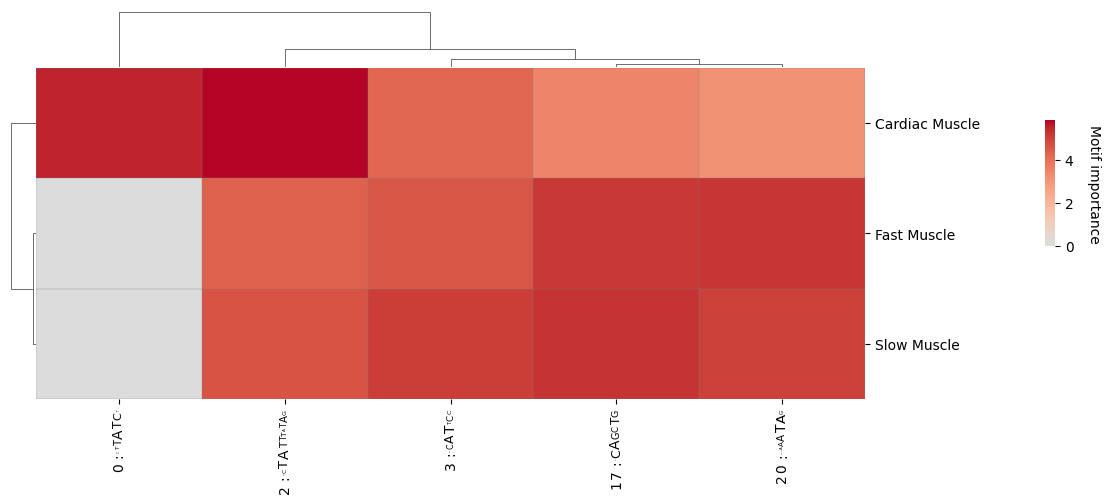

In [375]:
crested.pl.patterns.clustermap(
    pattern_matrix,
    list(matched_files.keys()),
    figsize=(10, 4.2),
    pat_seqs=pat_seqs,
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5
)

In [83]:
from dataclasses import dataclass
import h5py
from typing import Self
@dataclass
class Seqlet:
  contrib_scores: np.ndarray
  hypothetical_contrib_scores: np.ndarray
  ppm: np.ndarray
  start: int
  end: int
  region_name: str
  region_one_hot: np.ndarray
  is_revcomp: bool

  def __init__(
      self,
      p: h5py._hl.group.Group,
      seqlet_idx: int,
      ohs: np.ndarray,
      region_names: list[str]
  ):
    self.contrib_scores               = p["contrib_scores"][        seqlet_idx  ]
    self.hypothetical_contrib_scores  = p["hypothetical_contribs"][ seqlet_idx  ]
    self.ppm                          = p["sequence"][              seqlet_idx  ]
    self.start                        = p["start"][                 seqlet_idx  ]
    self.end                          = p["end"][                   seqlet_idx  ]
    self.is_revcomp                   = p["is_revcomp"][            seqlet_idx  ]
    region_idx                        = p["example_idx"][           seqlet_idx  ]
    self.region_name = region_names[region_idx]
    self.region_one_hot = ohs[region_idx]
    if (
        (not np.all(self.ppm == self.region_one_hot[self.start: self.end]) and not self.is_revcomp) or \
        (not np.all(self.ppm[::-1, ::-1] == self.region_one_hot[self.start: self.end]) and self.is_revcomp)
    ):
      raise ValueError(
        f"ppm does not match onehot\n" + \
        f"region_idx\t{region_idx}\n" + \
        f"start\t\t{self.start}\n" + \
        f"end\t\t{self.end}\n" + \
        f"is_revcomp\t{self.is_revcomp}\n" + \
        f"{self.ppm.argmax(1)}\n" + \
        f"{self.region_one_hot[self.start: self.end].argmax(1)}"
      )

  def __repr__(self):
    return f"Seqlet on {self.region_name} {self.start}:{self.end}"

@dataclass
class ModiscoPattern:
  contrib_scores: np.ndarray
  hypothetical_contrib_scores: np.ndarray
  ppm: np.ndarray
  is_pos: bool
  seqlets: list[Seqlet]
  subpatterns: list[Self] | None = None

  def __init__(self, p: h5py._hl.group.Group, is_pos: bool, ohs: np.ndarray, region_names: list[str]):
    self.contrib_scores               = p["contrib_scores"][:]
    self.hypothetical_contrib_scores  = p["hypothetical_contribs"][:]
    self.ppm                          = p["sequence"][:]
    self.is_pos                       = is_pos
    self.seqlets      = [Seqlet(p["seqlets"], i, ohs, region_names) for i in range(p["seqlets"]["n_seqlets"][0])]
    self.subpatterns  = [ModiscoPattern(p[sub], is_pos, ohs, region_names) for sub in p.keys() if sub.startswith("subpattern_")]

  def __repr__(self):
    return f"ModiscoPattern with {len(self.seqlets)} seqlets"

In [84]:
def load_pattern_from_modisco(filename, ohs, region_names):
    with h5py.File(filename) as f:
        for pos_neg in ["pos_patterns", "neg_patterns"]:
            if pos_neg not in f.keys():
                continue
            for pattern in f[pos_neg].keys():
                yield (
                  filename.split("/")[-1].rsplit(".", 1)[0]
                    + "_"
                    + pos_neg.split("_")[0]
                    + "_"
                    + pattern,
                  ModiscoPattern(f[pos_neg][pattern], pos_neg == "pos_patterns", ohs, region_names)
                )

In [137]:
all_pattern_names = []
all_patterns = []
for design_target in os.listdir("data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/"):
    designed_target_short = to_short[design_target + ".pkl"]
    print(designed_target_short)
    for cell_type in ["Cardiac muscle", "Fast muscle cells", "Slow muscle cells"]:
        ohs = np.load(
            "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
            design_target +"/" + "hpf72:"+ cell_type + "_oh.npz"
        )["arr_0"].swapaxes(1, 2)[:, 807:807 + 500, :]
        region_names = [f"{designed_target_short}_{i}" for i in range(ohs.shape[0])] 
        pattern_iter = load_pattern_from_modisco(
            filename = "data_prep/synthetic_enhancers/tfmodisco_cardiac_body_muscle/" + \
                        design_target +"/"  + "hpf72:" +  cell_type + "_modisco_results.h5",
            ohs=ohs,
            region_names=region_names
        )
        for pattern_name, pattern in pattern_iter:
            all_pattern_names.append(pattern_name)
            all_patterns.append(pattern)

ISE_mus_body_0.5_cardiac_1
ISE_mus_body_1_cardiac_0.5
ISE_mus_body_1_cardiac_0
ISE_mus_body_1_cardiac_1
ISE_mus_body_0_cardiac_1


In [143]:
all_patterns

96

In [147]:
def trim_by_ic(ic, min_v):
    if len(np.where(np.diff((ic > min_v) * 1))[0]) == 0:
        return 0, 0
    start_index = min(np.where(np.diff((ic > min_v) * 1))[0])
    end_index = max(np.where(np.diff((ic > min_v) * 1))[0])
    return start_index, end_index + 1

In [240]:
patterns_passing_filter = []
patterns_ic_start_stop = []
patterns_passing_filter_names = []
ic_thr = 0.2
avg_ic_thr=0.3
for pattern, name in zip(all_patterns, all_pattern_names):
    ic = modiscolite.util.compute_per_position_ic(
        ppm=pattern.ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    start, stop = trim_by_ic(ic, ic_thr)
    if stop - start <= 3:
        continue
    if ic[start:stop].mean() < avg_ic_thr:
        continue
    patterns_passing_filter.append(pattern)
    patterns_ic_start_stop.append(slice(start, stop))
    patterns_passing_filter_names.append(name)

In [241]:
len(patterns_passing_filter)

82

In [242]:
t_all_ppm = [
    torch.from_numpy(pattern.ppm[ic_start_stop]).T
    for pattern, ic_start_stop in zip(patterns_passing_filter, patterns_ic_start_stop)
]

In [243]:
pvals, scores, offsets, overlaps, strands = tomtom(
    t_all_ppm, t_all_ppm
)
evals = pvals.numpy() * len(t_all_ppm)

In [244]:
dat = 1 - np.corrcoef(evals)

row_linkage = hierarchy.linkage(
    distance.pdist(dat), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(dat.T), method='average')

clusters = hierarchy.fcluster(row_linkage, t = 12, criterion = "maxclust")

/data/projects/c04/cbd-saerts/sdewin/software/miniforge3/envs/crested_torch/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


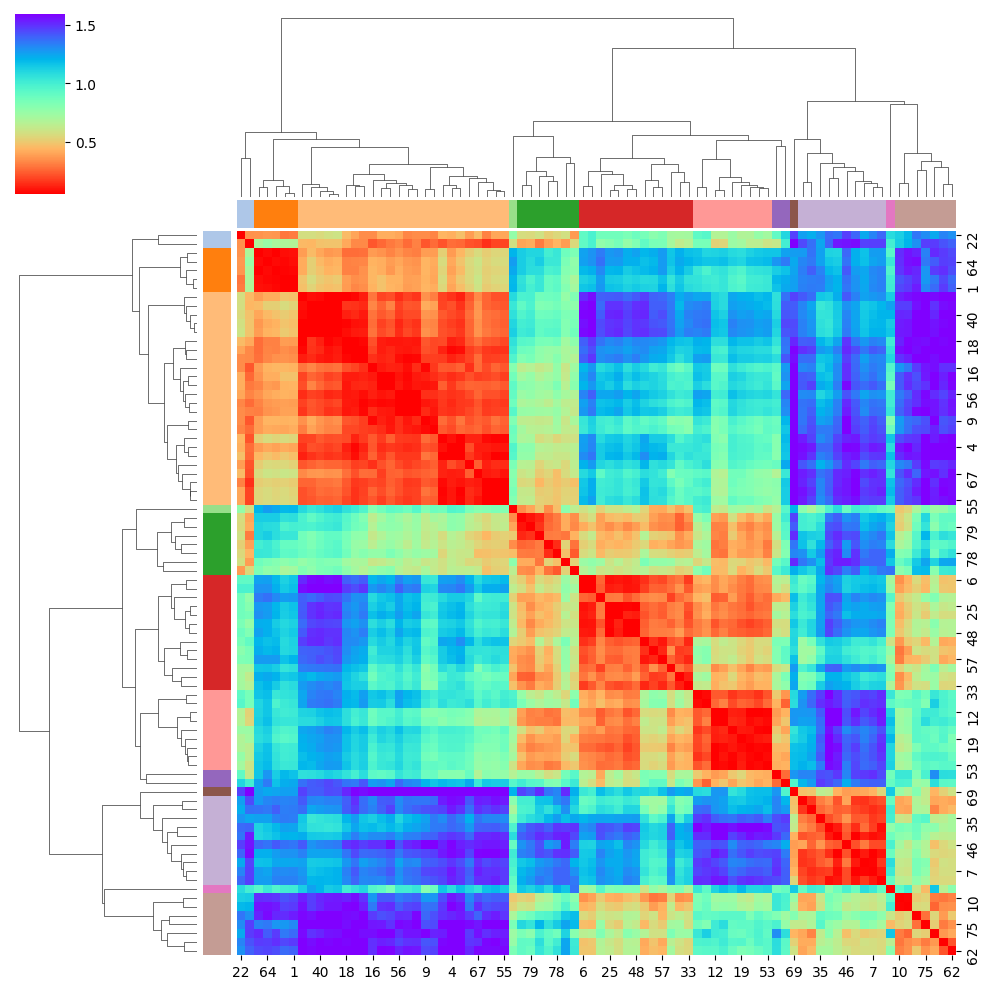

In [245]:
sns.clustermap(
    dat,
    robust = True, cmap = "rainbow_r",
    row_colors = [plt.cm.tab20(x) for x in clusters],
    col_colors = [plt.cm.tab20(x) for x in clusters]
)

CLUSTER: 1


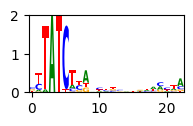

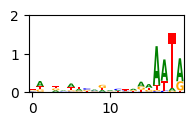

CLUSTER: 2


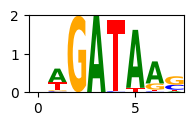

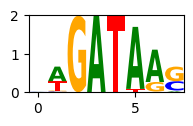

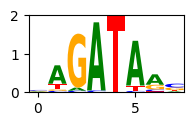

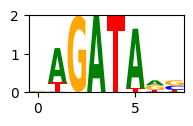

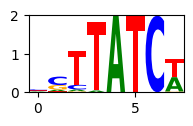

CLUSTER: 3


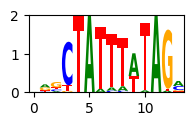

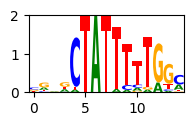

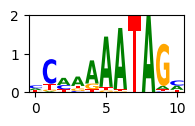

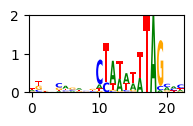

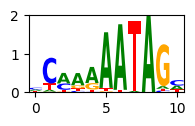

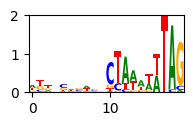

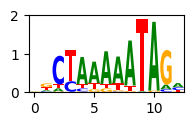

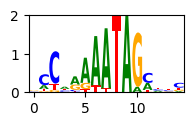

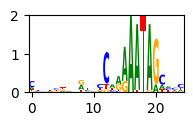

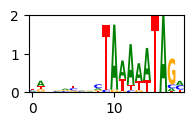

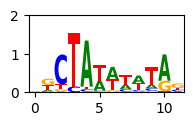

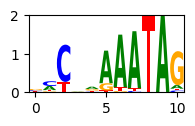

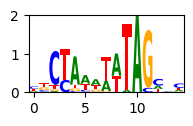

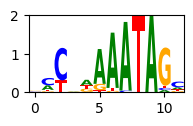

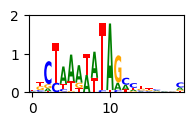

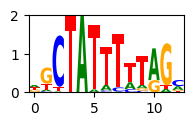

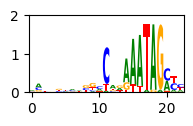

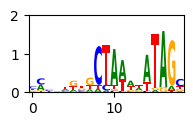

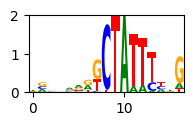

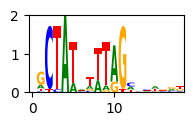

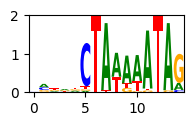

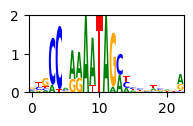

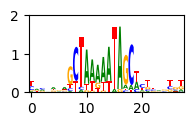

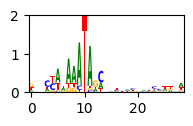

CLUSTER: 4


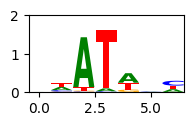

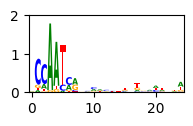

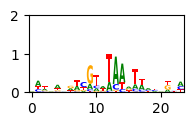

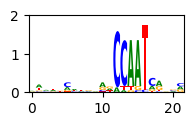

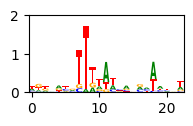

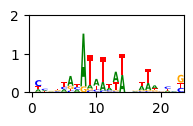

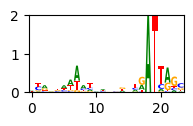

CLUSTER: 5


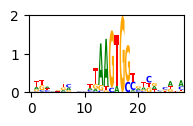

CLUSTER: 6


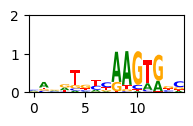

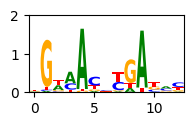

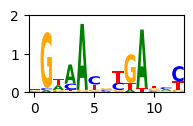

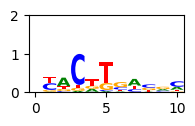

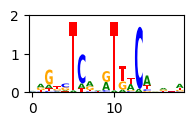

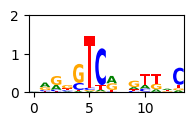

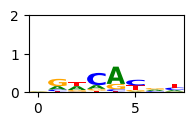

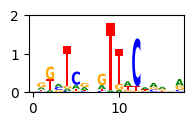

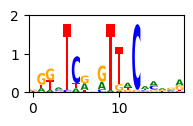

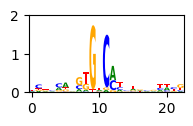

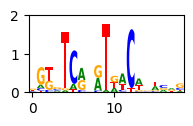

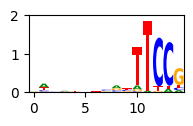

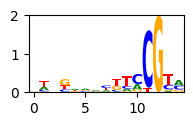

CLUSTER: 7


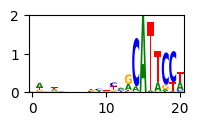

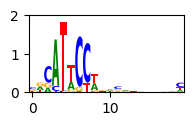

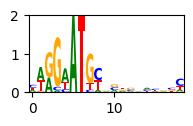

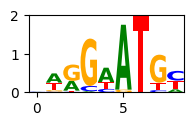

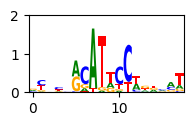

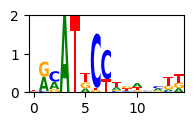

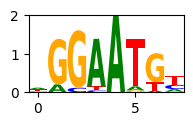

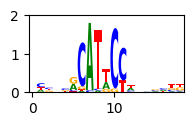

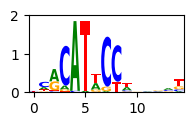

CLUSTER: 8


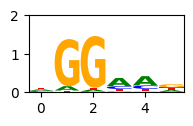

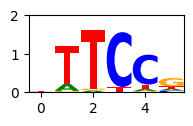

CLUSTER: 9


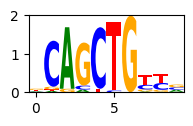

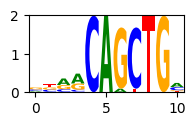

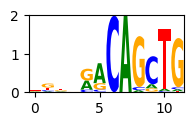

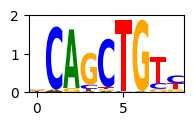

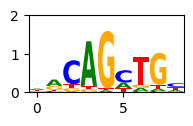

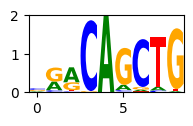

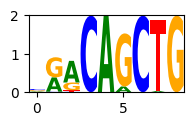

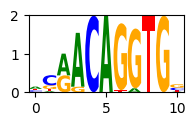

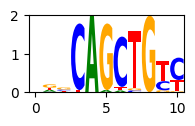

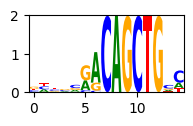

CLUSTER: 10


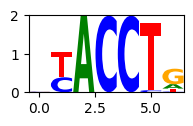

CLUSTER: 11


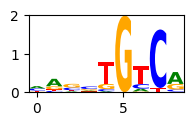

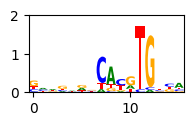

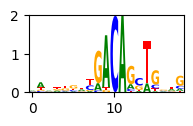

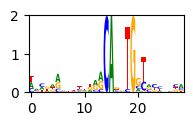

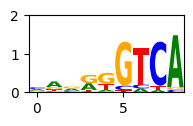

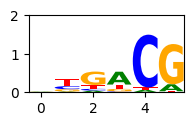

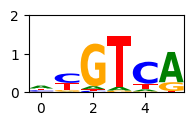

CLUSTER: 12


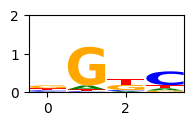

In [246]:
for cluster in np.unique(clusters):
    print(f"CLUSTER: {cluster}")
    for pattern_idx in np.where(clusters == cluster)[0]:
        fig, ax = plt.subplots(figsize = (2, 1))
        ppm = patterns_passing_filter[pattern_idx].ppm
        ic_start_stop = patterns_ic_start_stop[pattern_idx]
        ic = modiscolite.util.compute_per_position_ic(
            ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
        )
        _ = logomaker.Logo(
            pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
            ax = ax
        )
        ax.set_ylim((0, 2))
        plt.show(fig)
        plt.close(fig)

In [247]:
clusters_to_keep = [
  2, #GATA
  3, #MEF
  5, #NKX
  7, #TEAD
  9, #EBOX
  10, #ZEB
]

CLUSTER: 2


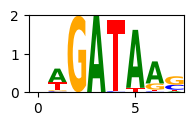

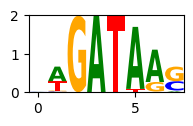

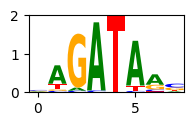

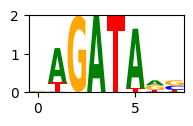

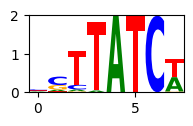

CLUSTER: 3


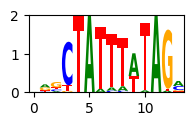

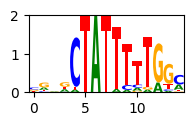

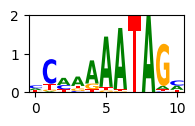

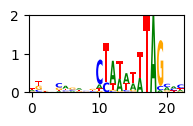

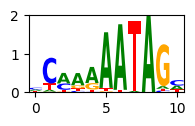

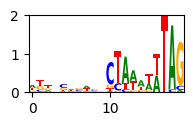

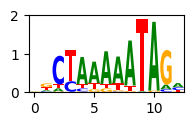

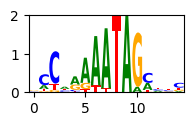

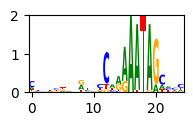

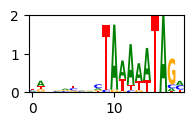

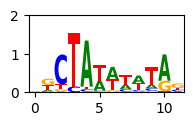

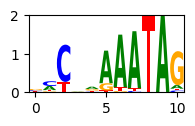

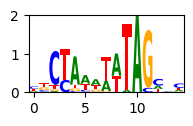

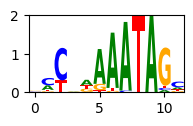

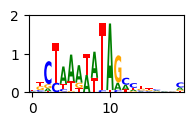

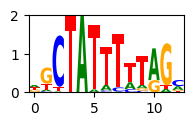

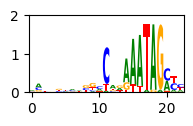

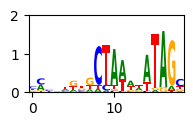

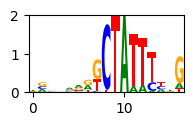

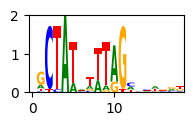

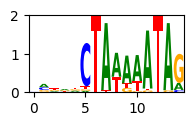

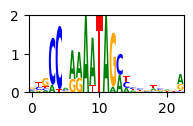

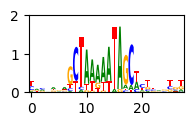

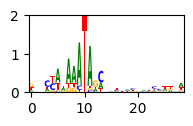

CLUSTER: 5


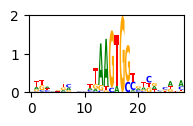

CLUSTER: 7


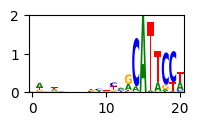

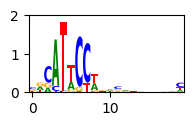

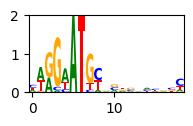

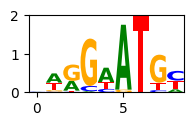

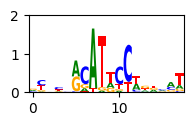

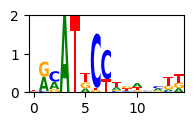

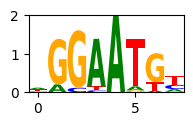

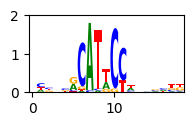

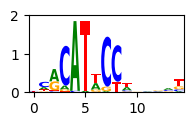

CLUSTER: 9


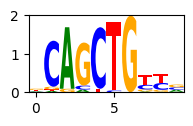

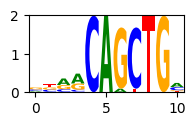

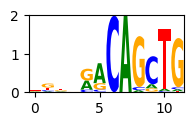

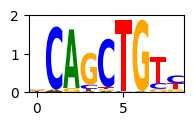

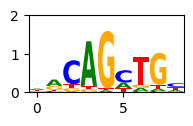

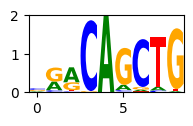

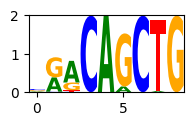

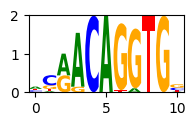

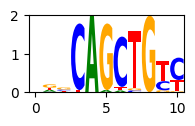

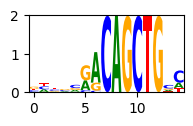

CLUSTER: 10


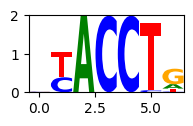

In [248]:
for cluster in clusters_to_keep:
    print(f"CLUSTER: {cluster}")
    for pattern_idx in np.where(clusters == cluster)[0]:
        fig, ax = plt.subplots(figsize = (2, 1))
        ppm = patterns_passing_filter[pattern_idx].ppm
        ic_start_stop = patterns_ic_start_stop[pattern_idx]
        ic = modiscolite.util.compute_per_position_ic(
            ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
        )
        _ = logomaker.Logo(
            pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
            ax = ax
        )
        ax.set_ylim((0, 2))
        plt.show(fig)
        plt.close(fig)

CLUSTER: 1


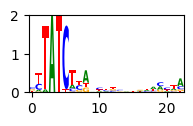

CLUSTER: 2


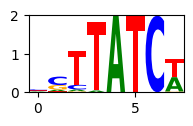

CLUSTER: 3


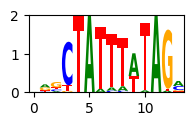

CLUSTER: 4


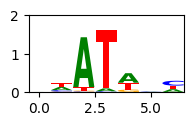

CLUSTER: 5


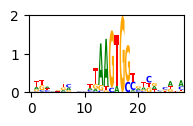

CLUSTER: 6


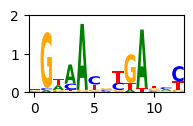

CLUSTER: 7


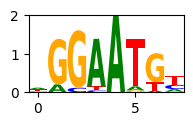

CLUSTER: 8


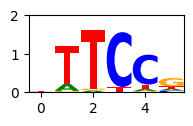

CLUSTER: 9


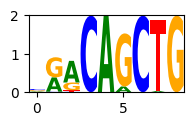

CLUSTER: 10


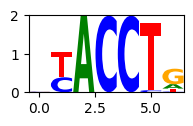

CLUSTER: 11


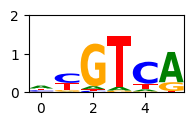

CLUSTER: 12


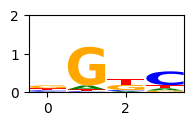

In [267]:
representative_pattern_per_cluster = {}
for cluster in np.unique(clusters):
    IC_MAX = -np.inf
    for pattern_idx in np.where(clusters == cluster)[0]:
        ppm = patterns_passing_filter[pattern_idx].ppm
        ic = modiscolite.util.compute_per_position_ic(
            ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
        )
        ic_start_stop = patterns_ic_start_stop[pattern_idx]
        if ic[ic_start_stop].mean() > IC_MAX:
            IC_MAX = ic[ic_start_stop].mean()
            representative_pattern_per_cluster[cluster] = (pattern_idx, patterns_passing_filter[pattern_idx])
    print(f"CLUSTER: {cluster}")
    pattern_idx, pattern = representative_pattern_per_cluster[cluster]
    fig, ax = plt.subplots(figsize = (2, 1))
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax
    )
    ax.set_ylim((0, 2))
    plt.show(fig)
    plt.close(fig)

In [268]:
representative_pattern_per_cluster

{1: (22, ModiscoPattern with 23 seqlets),
 2: (64, ModiscoPattern with 118 seqlets),
 3: (3, ModiscoPattern with 36 seqlets),
 4: (36, ModiscoPattern with 64 seqlets),
 5: (66, ModiscoPattern with 27 seqlets),
 6: (14, ModiscoPattern with 29 seqlets),
 7: (52, ModiscoPattern with 27 seqlets),
 8: (74, ModiscoPattern with 34 seqlets),
 9: (44, ModiscoPattern with 61 seqlets),
 10: (69, ModiscoPattern with 32 seqlets),
 11: (75, ModiscoPattern with 32 seqlets),
 12: (24, ModiscoPattern with 47 seqlets)}

In [258]:
cell_type_labels = np.unique([x.split("_modisco_results")[0] for x in patterns_passing_filter_names])

pattern_count_matrix = np.zeros(
    (len(cell_type_labels), len(clusters_to_keep))
)

for j, cluster in enumerate(clusters_to_keep):
     for pattern_idx in np.where(clusters == cluster)[0]:
         cell_type_name = patterns_passing_filter_names[pattern_idx].split("_modisco_results")[0]
         i = np.where(cell_type_labels == cell_type_name)
         pattern = patterns_passing_filter[pattern_idx]
         pattern_count_matrix[i, j] += len(pattern.seqlets)
         

In [269]:
pat_seqs[0]

('0:CTTATCT',
 array([1.        , 1.        , 0.19779025, 0.43254436, 0.73217676,
        1.        , 0.87564585, 0.80362781, 0.21251854]))

In [281]:
def scale(X):
    return (X - X.min()) / (X.max() - X.min())

CLUSTER: 2
CCTTATCT


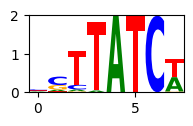

CLUSTER: 3
AAGCTATTTATAGA


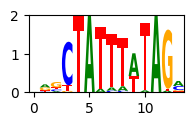

CLUSTER: 5
ATGAAGTCGCCTTAAGTGGCGTCACCATA


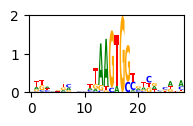

CLUSTER: 7
AGGAATGT


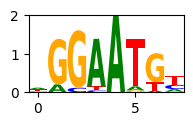

CLUSTER: 9
CGACAGCTG


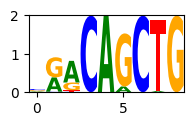

CLUSTER: 10
TTACCTG


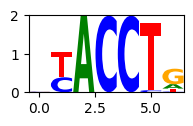

In [291]:
pat_seqs_new = []
for cluster in clusters_to_keep:
    print(f"CLUSTER: {cluster}")
    pattern_idx, pattern = representative_pattern_per_cluster[cluster]
    fig, ax = plt.subplots(figsize = (2, 1))
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )

    consensus = "".join(map(lambda nuc_idx: ["A", "C", "G", "T"][nuc_idx], (ppm * ic[:, None])[ic_start_stop].argmax(1)))
    val = scale((ppm * ic[:, None])[ic_start_stop].max(1))
    print(consensus)
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax
    )
    ax.set_ylim((0, 2))
    plt.show(fig)
    plt.close(fig)
    pat_seqs_new.append((f"{cluster}:{consensus}", val))
    

In [292]:
pat_seqs_new

[('2:CCTTATCT',
  array([0.        , 0.09905401, 0.44036198, 0.89017787, 1.        ,
         1.        , 1.        , 0.22337527])),
 ('3:AAGCTATTTATAGA',
  array([0.        , 0.03884115, 0.06938768, 0.56700236, 1.        ,
         1.        , 0.7980304 , 0.69182774, 0.62475617, 0.29576108,
         0.88334521, 1.        , 0.77231095, 0.06436403])),
 ('5:ATGAAGTCGCCTTAAGTGGCGTCACCATA',
  array([0.00359718, 0.07650933, 0.06348575, 0.0251127 , 0.00509479,
         0.01108179, 0.0507822 , 0.04325778, 0.        , 0.00509479,
         0.00509479, 0.04707597, 0.20991495, 0.54281221, 0.62000487,
         0.74948041, 0.6649144 , 1.        , 0.47990653, 0.11202892,
         0.03023539, 0.068267  , 0.08737462, 0.04079161, 0.00941778,
         0.03019902, 0.06477723, 0.00509479, 0.08164026])),
 ('7:AGGAATGT',
  array([0.        , 0.58425978, 0.74371235, 0.61125572, 1.        ,
         0.61125572, 0.3633577 , 0.10133202])),
 ('9:CGACAGCTG',
  array([0.        , 0.25102276, 0.27143196, 1.        

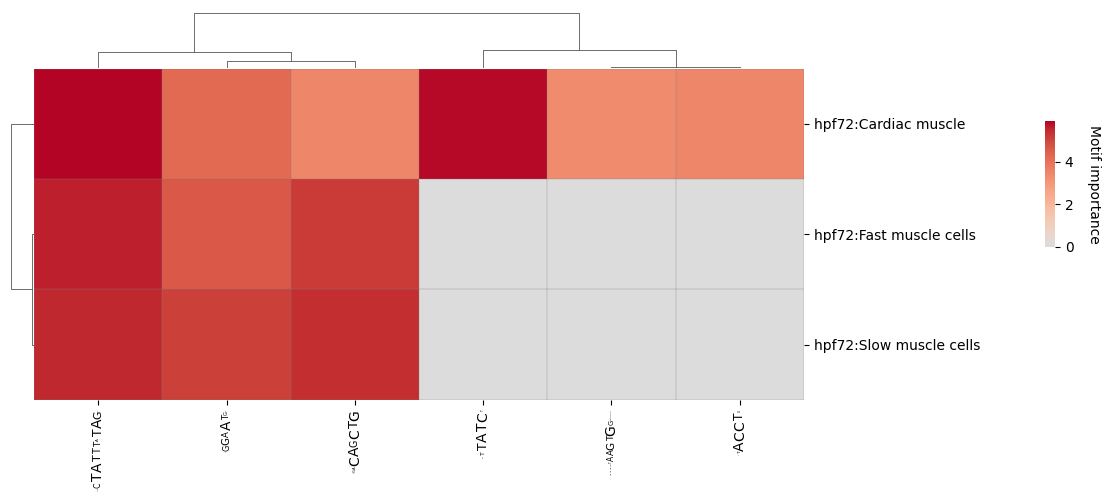

In [298]:
crested.pl.patterns.clustermap(
    np.log1p(pattern_count_matrix),
    cell_type_labels,
    figsize=(10, 4.2),
    pat_seqs=pat_seqs_new,
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold = -1
)

In [349]:
clusters_to_keep

[2, 3, 5, 7, 9, 10]

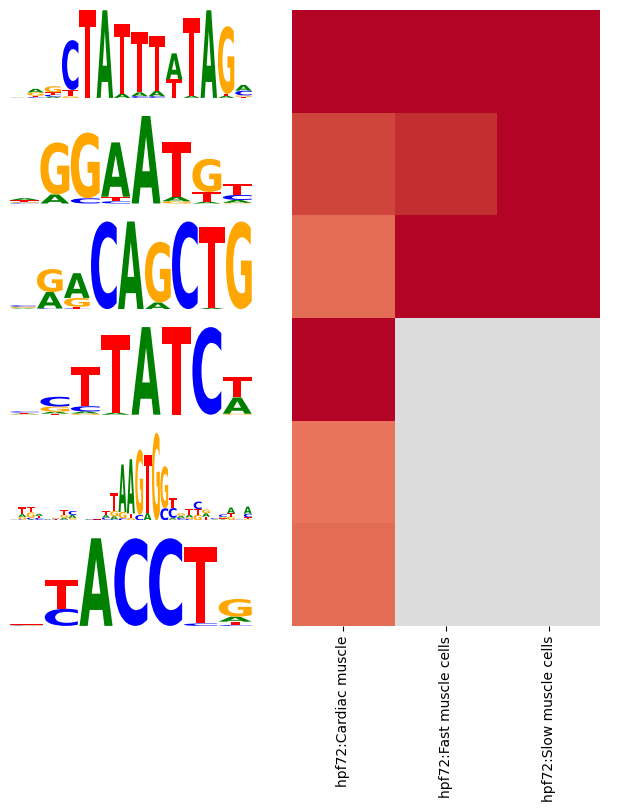

In [371]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.set_axis_off()
gs = fig.add_gridspec(
    6, 10,
)
ax_hm = fig.add_subplot(
    gs[0:6, 4:10]
)
sorted_idx = [1, 3, 4, 0, 2, 5]
sns.heatmap(
    np.log1p(pattern_count_matrix[:, sorted_idx]).T,
    yticklabels = False,#yticklabels = np.array([x[0] for x in pat_seqs_new])[sorted_idx],
    xticklabels = cell_type_labels,
    ax = ax_hm,
    cmap = "coolwarm",
    center = 0,
    square = True,
    cbar = False, cbar_kws=dict(shrink = 0.2),
    vmin = 0, vmax = 5
)
for i, idx in enumerate(sorted_idx):
    ax_pwm = fig.add_subplot(
        gs[i, 0:4]
    )
    cluster = clusters_to_keep[idx]
    pattern_idx, pattern = representative_pattern_per_cluster[cluster]
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax_pwm
    )
    ax_pwm.set_ylim((0, 2))
    ax_pwm.set_axis_off()

fig.show()

# Load endothelial patterns

In [392]:
all_pattern_names_endo = []
all_patterns_endo = []

design_target = "ISE_hpf72_Endothelial"
cell_type = "Endothelial"
ohs = np.load(
    "data_prep/synthetic_enhancers/contribution_scores_endothelial//" + \
    design_target +"/" + "hpf72:"+ cell_type + "_oh.npz"
)["arr_0"].swapaxes(1, 2)[:, 807:807 + 500, :]
region_names = [f"{designed_target_short}_{i}" for i in range(ohs.shape[0])] 
pattern_iter = load_pattern_from_modisco(
    filename = "data_prep/synthetic_enhancers/tfmodisco_endothelial//" + \
                design_target +"/"  + "hpf72:" +  cell_type + "_modisco_results.h5",
    ohs=ohs,
    region_names=region_names
)
for pattern_name, pattern in pattern_iter:
    all_patterns_endo.append(pattern_name)
    all_pattern_names_endo.append(pattern)

In [437]:
patterns_passing_filter_endo = []
patterns_ic_start_stop_endo = []
patterns_passing_filter_names_endo = []
ic_thr = 0.4
avg_ic_thr=0.3
for pattern, name in zip(all_patterns_endo, all_pattern_names_endo):
    ic = modiscolite.util.compute_per_position_ic(
        ppm=pattern.ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    start, stop = trim_by_ic(ic, ic_thr)
    if stop - start <= 3:
        continue
    if ic[start:stop].mean() < avg_ic_thr:
        continue
    patterns_passing_filter_endo.append(pattern)
    patterns_ic_start_stop_endo.append(slice(start, stop))
    patterns_passing_filter_names_endo.append(name)

In [438]:
len(all_patterns_endo)

4

In [439]:
len(patterns_passing_filter_endo)

4

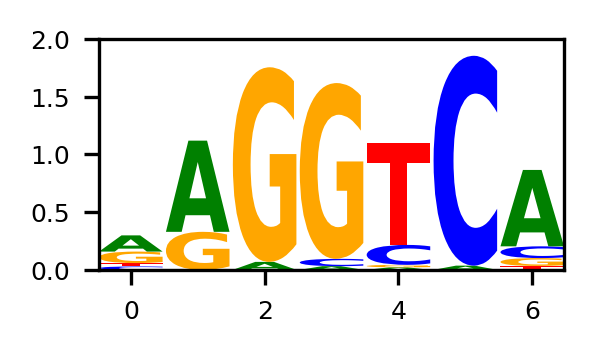

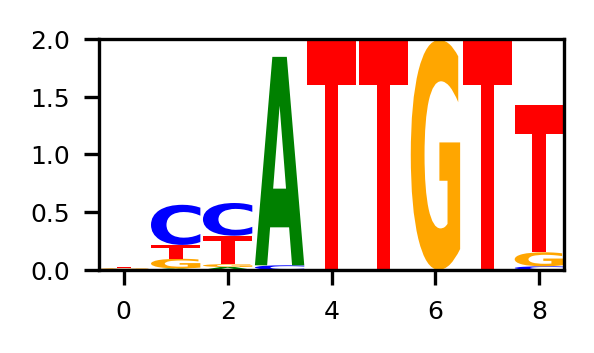

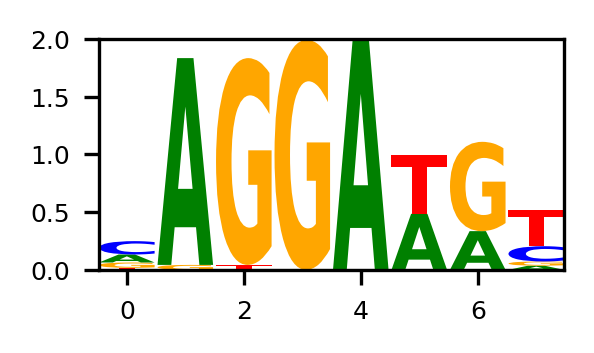

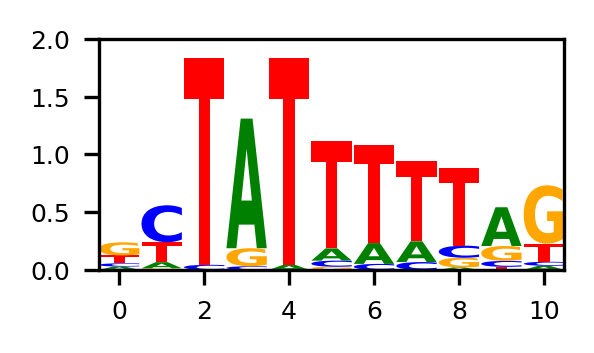

In [440]:
for pattern_idx, pattern in enumerate(patterns_passing_filter_endo):
    fig, ax = plt.subplots(figsize = (2, 1))
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop_endo[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax
    )
    ax.set_ylim((0, 2))
    plt.show(fig)
    plt.close(fig)

# Plot figure

In [380]:
N_PIXELS_PER_GRID = 50
plt.style.use(
    "../paper.mplstyle"
)
fig = plt.figure()
width, height = fig.get_size_inches()
n_w_pixels = fig.get_dpi() * width
n_h_pixels = fig.get_dpi() * height
ncols = int((n_w_pixels) // N_PIXELS_PER_GRID)
nrows = int((n_h_pixels) // N_PIXELS_PER_GRID)

START_EMB = ncols - 15
WIDTH_EMBR = 3
SPACE_EMBR_X = 0
SPACE_EMBR_Y = 1
SPACE_PLOTS = 2
y_offset = 0
HEIGHT_EMBR = 10

def create_embryo_axes(fig: plt.Figure, x_offset: int, y_offset, x_extra = 0, y_extra = 0) -> plt.Axes:
    ax_emb = fig.add_subplot(
        gs[
            y_offset * (HEIGHT_EMBR + SPACE_EMBR_Y) + y_extra: y_offset * (HEIGHT_EMBR + SPACE_EMBR_Y) + HEIGHT_EMBR + y_extra,
            x_offset * (WIDTH_EMBR  + SPACE_EMBR_X) + x_extra: x_offset * (WIDTH_EMBR  + SPACE_EMBR_X) + WIDTH_EMBR + x_extra
        ]
    )
    ax_emb.set_xticks([])
    ax_emb.set_yticks([])
    return ax_emb

plt.close(fig)

{'x': 11968, 'y': 7344, 't': 1, 'z': 51}
{'x': 12569, 'y': 6464, 'c': 2, 't': 1, 'z': 24}
{'x': 12512, 'y': 7616, 't': 1, 'z': 10}
{'x': 12569, 'y': 6464, 'c': 3, 't': 1, 'z': 6}
{'x': 12569, 'y': 6464, 'c': 3, 't': 1, 'z': 7}
{'x': 14960, 'y': 7616, 't': 1, 'z': 8}
{'x': 12569, 'y': 6464, 'c': 3, 't': 1, 'z': 9}
{'x': 2720, 'y': 10064, 't': 1, 'z': 14}
{'x': 11968, 'y': 7344, 't': 1, 'z': 78}
{'x': 2720, 'y': 2720, 't': 1, 'z': 107}
{'x': 12569, 'y': 6464, 'c': 3, 't': 1, 'z': 15}
{'x': 9656, 'y': 7344, 't': 1, 'z': 45}
{'x': 2720, 'y': 2720, 't': 165}
{'x': 11968, 'y': 7344, 't': 1, 'z': 66}
{'x': 2720, 'y': 2720, 't': 156}
{'x': 12569, 'y': 6464, 'c': 3, 't': 1, 'z': 18}
{'x': 12569, 'y': 6464, 'c': 2, 't': 1, 'z': 19}
{'x': 14960, 'y': 7616, 't': 1, 'z': 43}
{'x': 12569, 'y': 6464, 't': 1, 'z': 9}
{'x': 12569, 'y': 6464, 't': 1, 'z': 14}
{'x': 9656, 'y': 7344, 't': 1, 'z': 100}
{'x': 2720, 'y': 2720, 't': 166}


/data/tmp/24633/ipykernel_2786058/4231388863.py:776: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


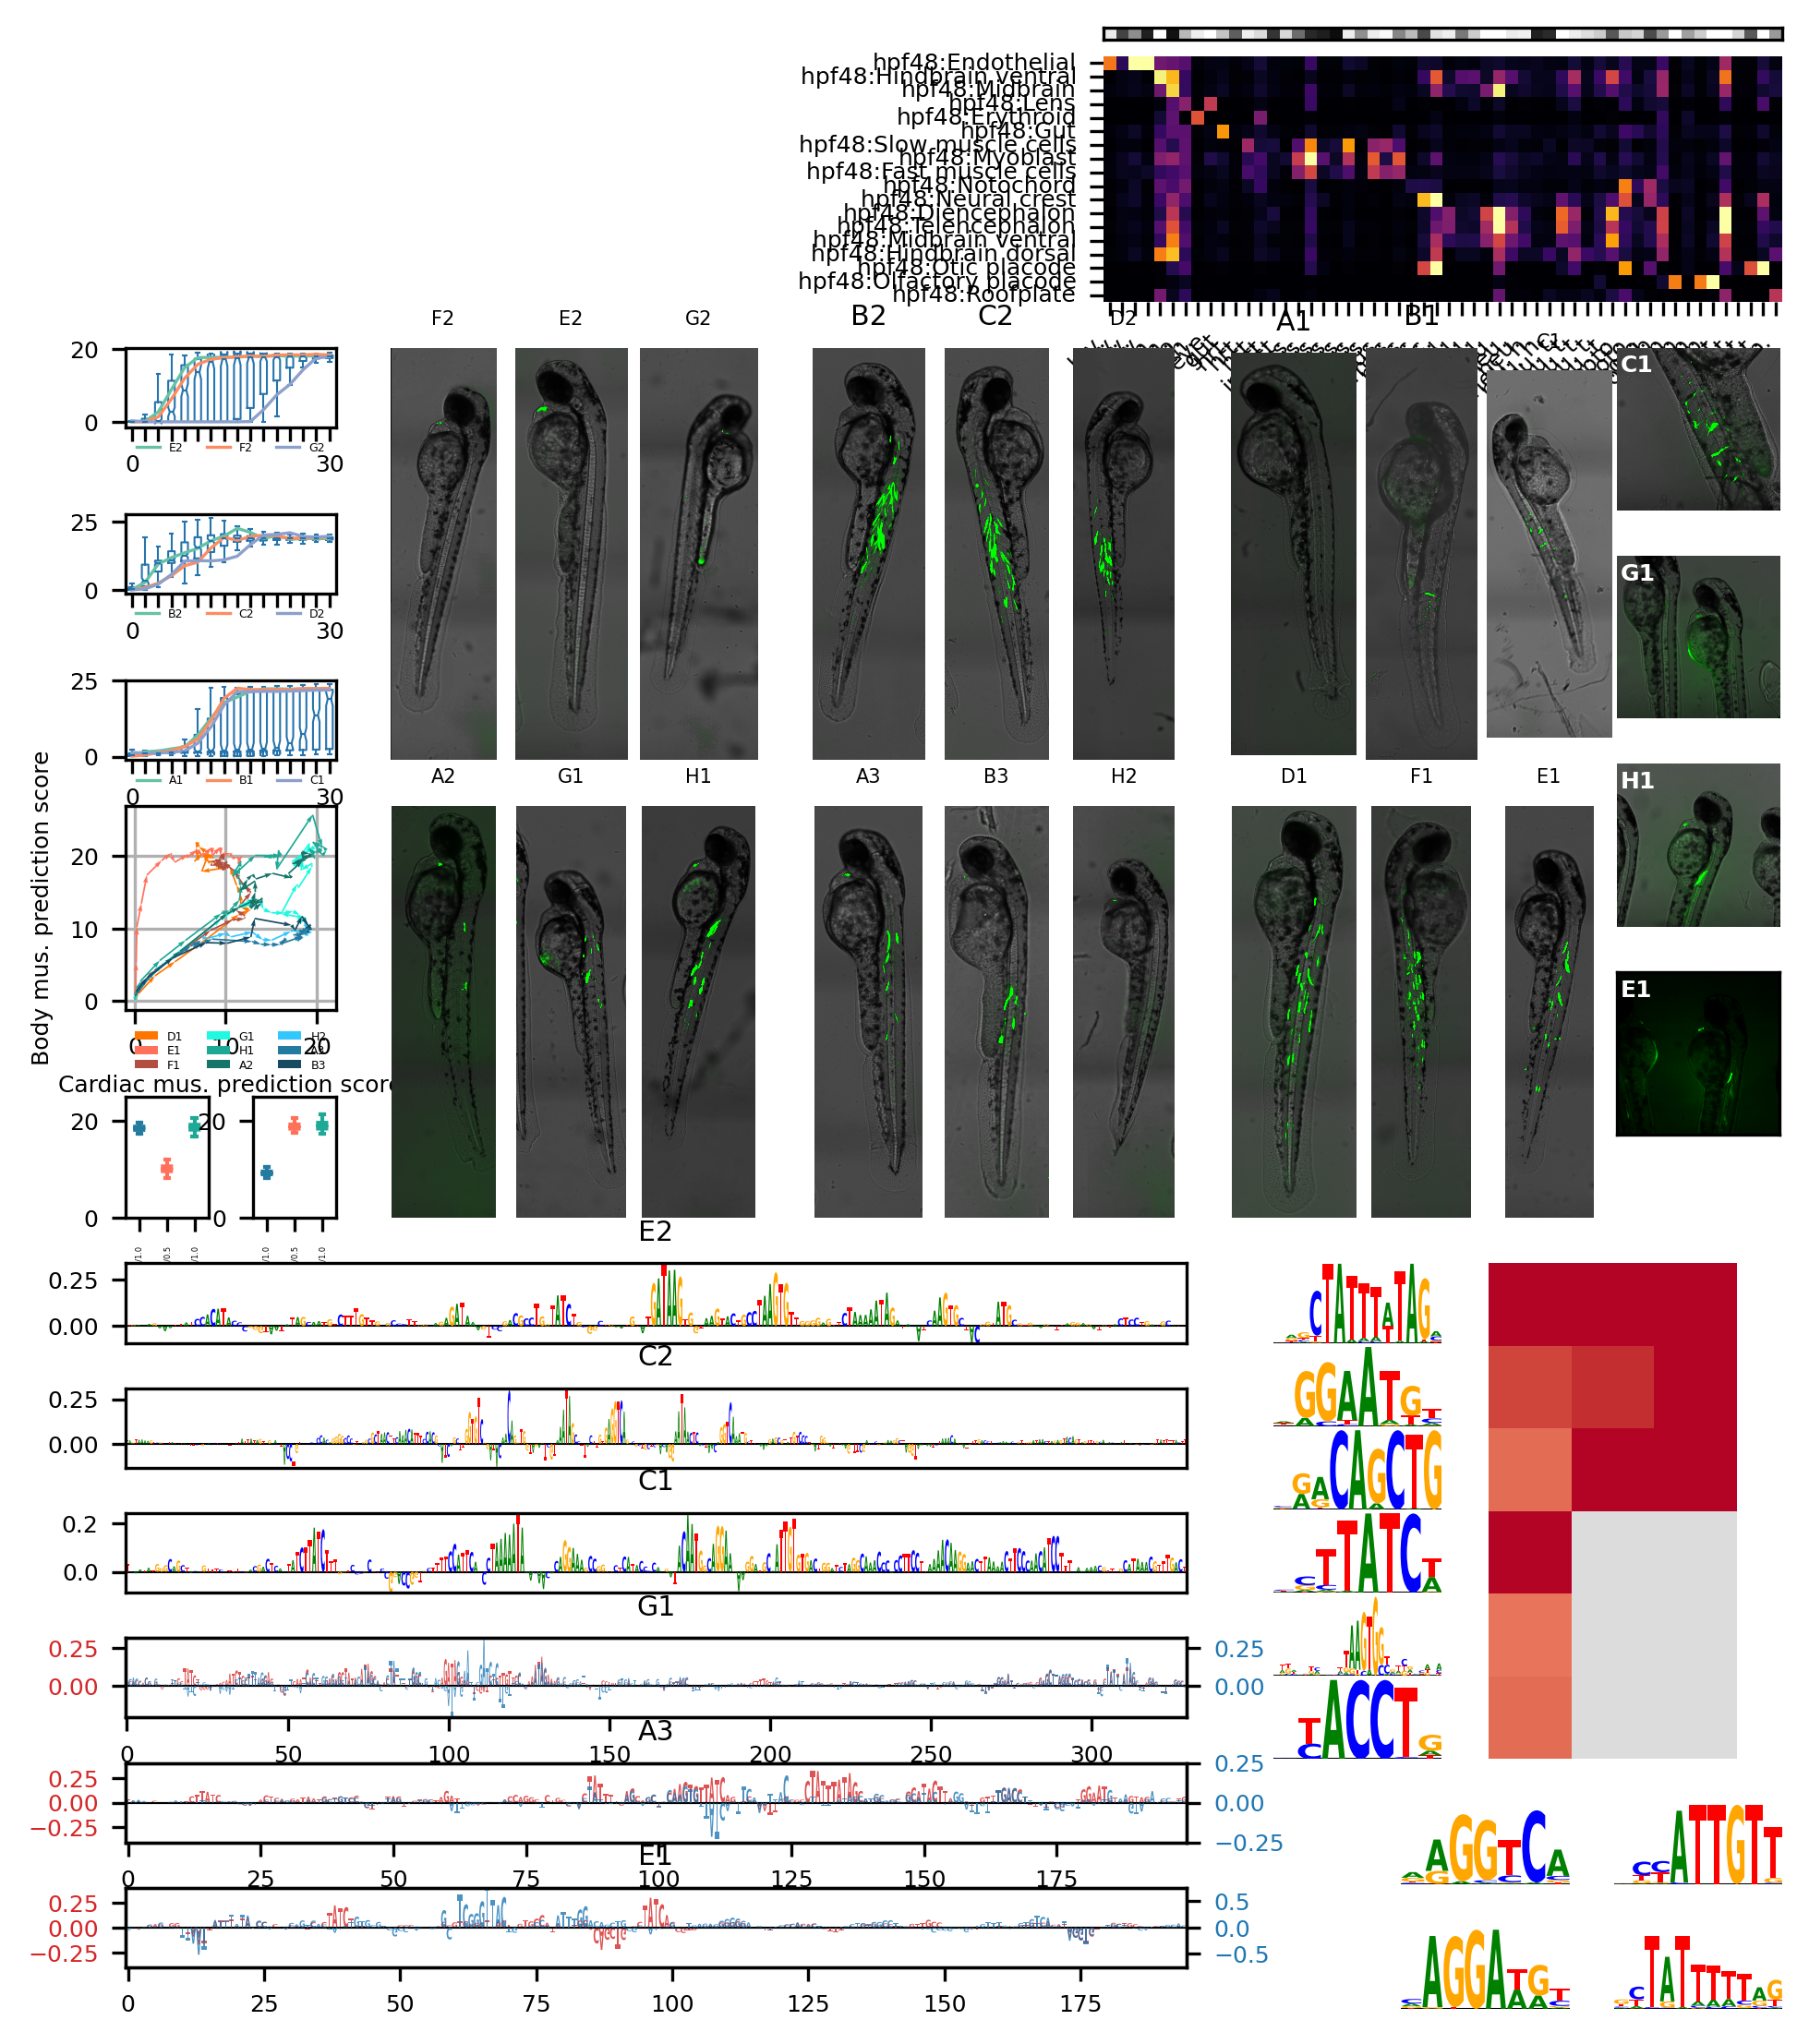

In [442]:
N_PIXELS_PER_GRID = 50

plt.style.use(
    "../paper.mplstyle"
)

fig = plt.figure()
width, height = fig.get_size_inches()
n_w_pixels = fig.get_dpi() * width
n_h_pixels = fig.get_dpi() * height
ncols = int((n_w_pixels) // N_PIXELS_PER_GRID)
nrows = int((n_h_pixels) // N_PIXELS_PER_GRID)



gs = fig.add_gridspec(
    nrows, ncols, wspace=0.05, hspace=0.1, left=0.05, right=0.97, bottom=0.05, top=0.95
)

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                           HEATMAP                                                                             #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################


heatmap_w = 16
ax_color_bar = fig.add_subplot(
    gs[0:1, ncols - heatmap_w: ncols]
)
ax_heatmap = fig.add_subplot(
    gs[
        1: 7,
        ncols - heatmap_w: ncols
    ]
)
ax_color_bar, ax_heatmap = plot_enhancer_pred_heatmap([ax_color_bar, ax_heatmap])

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                         PRED SCORES                                                                           #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################

y_current = 8

ax_car_t = fig.add_subplot(
    gs[
        y_current: y_current + 2,
        0: 5
    ]
)

ax_bod_t = fig.add_subplot(
    gs[
        y_current + 4: y_current + 6,
        0: 5
    ]
)

ax_end_t = fig.add_subplot(
    gs[
        y_current + 8: y_current + 10,
        0: 5
    ]
)

ax_car_t = plot_boxplot_pred_scores(
    ax=ax_car_t,
    class_idx=np.where(adata.obs_names == "hpf48:Cardiac muscle")[0][0],
    synth_metadata=cardiac_metadata,
    to_highlight=tested_enhancers_cardiac,
    highlight_names=tested_enhancers_cardiac_names
)

ax_bod_t = plot_boxplot_pred_scores(
    ax=ax_bod_t,
    class_idx=np.where(adata.obs_names == "hpf48:Fast muscle cells")[0][0],
    synth_metadata=body_metadata,
    to_highlight=tested_enhancers_body,
    highlight_names=tested_enhancers_body_names
)

ax_end_t = plot_boxplot_pred_scores(
    ax=ax_end_t,
    class_idx=np.where(adata.obs_names == "hpf48:Endothelial")[0][0],
    synth_metadata=endo_metadata,
    to_highlight=tested_enhancers_endo,
    highlight_names=tested_enhancers_endo_names
)

ax_double_scat = fig.add_subplot(
    gs[
        y_current + 11: y_current + 16,
        0: 5
    ]
)

ax_double_box_1 = fig.add_subplot(
    gs[
        y_current + 18: y_current + 21,
        0: 2
    ]
)
ax_double_box_2 = fig.add_subplot(
    gs[
        y_current + 18: y_current + 21,
        3: 5
    ]
)

ax_double_scat = plot_dual(ax_double_scat)

ax_double_box_1 = plot_boxplot_pred_scores_dual(ax_double_box_1, np.where(adata.obs_names == "hpf48:Cardiac muscle")[0][0])
ax_double_box_2 = plot_boxplot_pred_scores_dual(ax_double_box_2, np.where(adata.obs_names == "hpf48:Fast muscle cells")[0][0])
ax_double_box_1.set_ylim(0, 25)
ax_double_box_2.set_ylim(0, 25)
ax_double_box_1.set_xticklabels(ax_double_box_1.get_xticklabels(), rotation=90, fontsize = 2)
ax_double_box_2.set_xticklabels(ax_double_box_2.get_xticklabels(), rotation=90, fontsize = 2)

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                    EMBRYO IMAGES                                                                              #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################

axs_emb = np.empty((9, 2), dtype = "object")

for y in range(2):
    for x in range(3):
        axs_emb[x, y] = create_embryo_axes(fig, x, y, x_extra = 6, y_extra = y_current)
    
    for x in range(3):
        axs_emb[x + 3, y] = create_embryo_axes(fig, x + 3, y, x_extra = 1 + 6, y_extra = y_current)
    
    for x in range(3):
         axs_emb[x + 6, y] = create_embryo_axes(fig, x + 6, y, x_extra = 2 + 6, y_extra = y_current)


plot_big = True
if True:
    if plot_big:
        ax = plot_image(
            ax=axs_emb[0, 0],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_F2_Dish10_DIA_.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_F2_Dish10_GFP_.nd2"),
            embryo_index=0,
            green_vmin=145,
            green_vmax=160,
            y_cut_top=1000,
            embryos_to_keep=[
                (0, 1500),
                (1500, 3100),
                (3100, 5000),
                (5250, 6500),
                (7000, 8500),
                (8500, 10000),
                (10000, 11500)
            ]
        )
        ax.set_title("F2", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[1, 0],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250110_Zebrafish/KSEXP20250110_Zebrafish_E2_Dish2_001.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250110_Zebrafish/KSEXP20250110_Zebrafish_E2_Dish2_.nd2"),
            embryo_index=2,
            green_vmin=250,
            green_vmax=800,
            y_cut_top=1500,
            embryos_to_keep=[
                (2750, 3800),
                (4000, 5500),
                (5400, 6750),
                (7000, 8250),
                (8500, 9750)
            ]
        )
        ax.set_title("E2", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[2, 0],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_G2_IX001.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_G2_IX002.nd2"),
            embryo_index=4,
            green_vmin=140,
            green_vmax=150,
            y_cut_top=1000,
            embryos_to_keep=[
                (1250, 2700),
                (2700, 4250),
                (4750, 6500),
                (6500, 7750),
                (7750, 9500),
                (10500, 12200)
            ]
        )
        ax.set_title("G2", fontsize = 5)
        
        ax = plot_image_1(
            ax=axs_emb[3, 0],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250123_Zebrafish/KSEXP20250123_Zebrafish_B2_DishII.nd2"),
            embryo_index=5,
            green_vmin=120,
            green_vmax=350,
            y_cut_top=1000,
            embryos_to_keep=[
                (1250, 2500),
                (2400, 3700),
                (3750, 5000),
                (5000, 6250),
                (6250, 7450),
                (7400, 8750),
                (8750, 10250)
            ]
        )
        ax.set_title("B2")
        
        ax = plot_image_1(
            ax=axs_emb[4, 0],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250123_Zebrafish/KSEXP20250123_Zebrafish_C2_DishIV.nd2"),
            embryo_index=3,
            green_vmin=120,
            green_vmax=350,
            y_cut_top=500,
            embryos_to_keep=[
                (500, 2000),
                (1750, 3600),
                (3450, 5250),
                (5250, 6500),
                (6750, 7900),
                (7900, 9000),
                (9200, 10400)
            ]
        )
        ax.set_title("C2")
        
        ax = plot_image(
            ax=axs_emb[5, 0],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_D2_DishIV.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_D2_DishIV001.nd2"),
            embryo_index=3,
            green_vmin=150,
            green_vmax=400,
            y_cut_top=1000,
            embryos_to_keep=[
                (2250, 3750),
                (3750, 5250),
                (5250, 7000),
                (7000, 8500),
                (8500, 10000),
                (10000, 11750),
                (11750, 13250)
            ]
        )
        ax.set_title("D2", fontsize = 5)
        
        ax = plot_image_1(
            ax=axs_emb[6, 0],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250123_Zebrafish/KSEXP20250123_Zebrafish_A1_DishI.nd2"),
            embryo_index=1,
            green_vmin=120,
            green_vmax=250,
            y_cut_top=1000,
            embryos_to_keep=[
                (2250, 4050),
                (4050, 5600),
                (5750, 7250),
                (7600, 9000),
                (9000, 10200)
            ]
        )
        ax.set_title("A1")
        
        ax = plot_image_2(
            ax=axs_emb[7, 0],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_B1_DishII004.nd2"),
            path_to_image_bright=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_B1_DishII003.nd2"),
            green_vmin=150,
            green_vmax=200,
            y_cut_top=0
        )
        ax.set_title("B1")
        
        
        ax = plot_image(
            ax=axs_emb[8, 0],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_C1_Dish4_dia_.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_C1_Dish4_GFP_.nd2"),
            embryo_index=1,
            green_vmin=150,
            green_vmax=180,
            y_cut_top=1000,
            embryos_to_keep=[
                (750, 2600),
                (3000, 5000),
                (5000, 7000),
                (7000, 8750),
                (8750, 10250)
            ]
        )
        ax.set_title("C1", fontsize = 5)
    
    
    
    ax = fig.add_subplot(
        gs[y_current + 0:y_current + 4, 35: 39]
    )
    ax = plot_image_2(
        ax=ax,
        path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_C1_Dish4_embryo2_gfp_.nd2"),
        path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_C1_Dish4_embryo2_dia_.nd2"),
        green_vmin=130,
        green_vmax=180,
        y_cut_top=0
    )
    ax.text(0.025, 0.85, "C1", fontweight = "bold", color = "white", transform=ax.transAxes)

    if plot_big:
        ax = plot_image_1(
            ax=axs_emb[0, 1],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250123_Zebrafish_A2_DishI006.nd2"),
            embryo_index=0,
            green_vmin=120,
            green_vmax=200,
            y_cut_top=1000,
            embryos_to_keep=[
                (250, 1500),
                (1500, 2900),
                (3100, 4400),
                (4400, 6200),
                (6500, 8000),
                (7900, 9400),
                (9200, 11750)
            ]
        )
        ax.set_title("A2", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[1, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_G1_Dish11_DIA_001.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_G1_Dish11_GFP_.nd2"),
            embryo_index=5,
            green_vmin=145,
            green_vmax=160,
            y_cut_top=800,
            embryos_to_keep=[
                (0, 1750),
                (1750, 3000),
                (2500, 4000),
                (3500, 5250),
                (5250, 6500),
                (6200, 7750),
                (8000, 9600)
            ]
        )
        ax.set_title("G1", fontsize = 5)
    
    ax = fig.add_subplot(
        gs[y_current + 5:y_current + 9, 35: 39]
    )
    ax = plot_image_t(
        ax=ax,
        path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_G1_Embryo_6_Dish11_GFP_MOV.nd2"),
        path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_G1_Embryo_6_Dish11_DIA_.nd2"),
        green_vmin=130,
        green_vmax=180,
        y_cut_top=0
    )
    ax.text(0.025, 0.85, "G1", fontweight = "bold", color = "white", transform=ax.transAxes)

    if plot_big:
        ax = plot_image(
            ax=axs_emb[2, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_H1_Dish_B1_DIA_.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_H1_Dish_B1_GFP_.nd2"),
            embryo_index=3,
            green_vmin=145,
            green_vmax=170,
            y_cut_top=500,
            embryos_to_keep= [
                (500, 2000),
                (2000, 3400),
                (3750, 5000),
                (5000, 6600),
                (6600, 8000),
                (8000, 9500),
                (9500, 11000)
            ]
        )
        ax.set_title("H1", fontsize = 5)
    
    ax = fig.add_subplot(
        gs[y_current + 10:y_current + 14, 35: 39]
    )
    ax = plot_image_t(
        ax=ax,
        path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_H1_Dish_B1_Embryo_4_GFP_MOV.nd2"),
        path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_H1_Dish_B1_Embryo_4_DIA_.nd2"),
        green_vmin=130,
        green_vmax=180,
        y_cut_top=0
    )
    ax.text(0.025, 0.85, "H1", fontweight = "bold", color = "white", transform=ax.transAxes)

    if plot_big:
        ax = plot_image_1(
            ax=axs_emb[3, 1],
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250123_Zebrafish_A3_DishIV001.nd2"),
            embryo_index=4,
            green_vmin=140,
            green_vmax=180,
            y_cut_top=100,
            embryos_to_keep= [
                (1100, 2500),
                (2900, 4250),
                (4750, 6250),
                (6500, 8000),
                (8000, 9300),
                (9500, 10800)
            ]
        )
        ax.set_title("A3", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[4, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_B3_DishVI.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_B3_DishVI001.nd2"),
            embryo_index=3,
            green_vmin=140,
            green_vmax=180,
            y_cut_top=1000,
            embryos_to_keep= [
                (1600, 3000),
                (3250, 4500),
                (5000, 6250),
                (6500, 7750),
                (7750, 9250),
                (9250, 11000)
            ]
        )
        ax.set_title("B3", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[5, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_H2_DishX.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSESXP20250130_Zebrafish/KSEXP20250130_Zebrafish_H2_DishX001.nd2"),
            embryo_index=1,
            green_vmin=140,
            green_vmax=170,
            y_cut_top=1000,
            embryos_to_keep=[
                (1000, 2500),
                (2500, 4000),
                (4000, 5500),
                (5500, 6800),
                (6800, 8000),
                (8000, 9250),
                (9250, 13500)
            ]
        )
        ax.set_title("H2", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[6, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_D1_DishVIII003.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_D1_DishVIII004.nd2"),
            embryo_index=1,
            green_vmin=120,
            green_vmax=220,
            y_cut_top=700,
            embryos_to_keep=[
                (1000, 2300),
                (2750, 4250),
                (4250, 5750),
                (5750, 7100),
                (7100, 8750),
                (8750, 10000),
                (10000, 11400)
            ]
        )
        ax.set_title("D1", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[7, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_F1_DishXI.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250124_Zebrafish/KSEXP20250124_Zebrafish_F1_DishXI002.nd2"),
            embryo_index=7,
            green_vmin=130,
            green_vmax=200,
            y_cut_top=1000,
            embryos_to_keep=[
                (200, 2250),
                (2250, 3750),
                (3750, 5000),
                (5000, 6500),
                (6500, 7750),
                (8000, 9250),
                (9250, 10500),
                (10600, 11800)
            ]
        )
        ax.set_title("F1", fontsize = 5)
        
        ax = plot_image(
            ax=axs_emb[8, 1],
            path_to_image_bright=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_E1_Dish6_DIA_.nd2"),
            path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_E1_Dish6_GFP_.nd2"),
            embryo_index=4,
            green_vmin=150,
            green_vmax=165,
            y_cut_top=1000,
            embryos_to_keep=[
                (400, 1600),
                (2000, 3250),
                (3250, 5000),
                (5000, 6500),
                (6500, 7750),
                (8000, 9250)
            ]
        )
        ax.set_title("E1", fontsize = 5)
    
    
    ax = fig.add_subplot(
        gs[y_current + 15:y_current + 19, 35: 39]
    )
    ax = plot_image_t_2(
        ax=ax,
        path_to_image_gfp=os.path.join(IM_FOLDER, "KSEXP20250131_Zebrafish/KSEXP20250131_Zebrafish_E1_Dish6_embryo5_GFP_mov002.nd2"),
        green_vmin=130,
        green_vmax=180,
        y_cut_top=0
    )
    ax.text(0.025, 0.85, "E1", fontweight = "bold", color = "white", transform=ax.transAxes)

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                   DEEP EXPLAINERS                                                                             #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################

y_current = 30

ax_de_car = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)

y_current = 33

ax_de_bod = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)

y_current = 36

ax_de_endo = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)


y_current = 39

ax_de_1_1 = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)

y_current = 42

ax_de_5_1 = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)


y_current = 45

ax_de_1_5 = fig.add_subplot(
    gs[y_current: y_current + 2, 0: 25]
)

selected_enhancer=tested_enhancers_cardiac[0]
ax_de_car = plot_attr(
    ax=ax_de_car,
    selected_enhancer=selected_enhancer,
    path= "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
          "ISE_Slow_muscle_cell_0_Slow_muscle_cells_0_Fast_muscle_cells_0_Heart_0_Heart_field_0_Cardiac_muscle_1/" + \
          "hpf72:Cardiac muscle",
    zoom=slice(807 + 150, 807 + 500 - 150)
)
ax_de_car.set_xticks([])
ax_de_car.set_title(tested_enhancers_cardiac_names[tested_enhancers_cardiac.index(selected_enhancer)])

selected_enhancer=tested_enhancers_body[1]
ax_de_bod = plot_attr(
    ax=ax_de_bod,
    selected_enhancer=selected_enhancer,
    path= "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
          "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0/" + \
          "hpf72:Fast muscle cells",
    zoom=slice(807 - 50, 807 + 500 - 200)
)
ax_de_bod.set_xticks([])
ax_de_bod.set_title(tested_enhancers_body_names[tested_enhancers_body.index(selected_enhancer)])

selected_enhancer=tested_enhancers_endo[2]
ax_de_endo = plot_attr(
    ax=ax_de_endo,
    selected_enhancer=selected_enhancer,
    path= "data_prep/synthetic_enhancers/contribution_scores_endothelial/" + \
          "ISE_hpf72_Endothelial/" + \
          "hpf72:Endothelial",
    zoom=slice(807 + 150 , 807 + 500 - 100) 
)
ax_de_endo.set_xticks([])
ax_de_endo.set_title(tested_enhancers_endo_names[tested_enhancers_endo.index(selected_enhancer)])

selected_enhancer=tested_enhancers_body_cardiac["ISE_mus_body_1_cardiac_1"][0]
ax_de_1_1_car, ax_de_1_1_bod  = plot_attr_dual(
    ax1=ax_de_1_1,
    selected_enhancer=selected_enhancer,
    path_car = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1/" + \
               "hpf72:Cardiac muscle",
    path_bod = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_1/" + \
               "hpf72:Fast muscle cells",
    zoom=slice(807, 807 + 500 - 170)
)
ax_de_1_1_car.set_title(
    tested_enhancers_body_cardiac_names["ISE_mus_body_1_cardiac_1"][
        tested_enhancers_body_cardiac["ISE_mus_body_1_cardiac_1"].index(selected_enhancer)
    ]
)


selected_enhancer=tested_enhancers_body_cardiac["ISE_mus_body_0.5_cardiac_1"][1]
ax_de_5_1_car, ax_de_5_1_bod  = plot_attr_dual(
    ax1=ax_de_5_1,
    selected_enhancer=selected_enhancer,
    path_car = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1/" + \
               "hpf72:Cardiac muscle",
    path_bod = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_0.5_Slow_muscle_cells_0.5_Fast_muscle_cells_0.5_Heart_0_Heart_field_0_Cardiac_muscle_1/" + \
               "hpf72:Fast muscle cells",
    zoom=slice(1050, 1250)
)
ax_de_5_1_car.set_ylim(-0.4, 0.4)
ax_de_5_1_bod.set_ylim(-0.25, 0.25)
ax_de_5_1_car.set_title(
    tested_enhancers_body_cardiac_names["ISE_mus_body_0.5_cardiac_1"][
        tested_enhancers_body_cardiac["ISE_mus_body_0.5_cardiac_1"].index(selected_enhancer)
    ]
)


selected_enhancer=tested_enhancers_body_cardiac["ISE_mus_body_1_cardiac_0.5"][1]
ax_de_1_5_car, ax_de_1_5_bod  = plot_attr_dual(
    ax1=ax_de_1_5,
    selected_enhancer=selected_enhancer,
    path_car = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5/" + \
               "hpf72:Cardiac muscle",
    path_bod = "data_prep/synthetic_enhancers/contribution_scores_cardiac_body_muscle/" + \
               "ISE_Slow_muscle_cell_1_Slow_muscle_cells_1_Fast_muscle_cells_1_Heart_0_Heart_field_0_Cardiac_muscle_0.5/" + \
               "hpf72:Fast muscle cells",
    zoom=slice(807 + 125, 807 + 320)
)
ax_de_1_5_car.set_ylim(-0.4, 0.4)
ax_de_1_5_bod.set_ylim(-0.75, 0.75)
ax_de_1_5_car.set_title(
    tested_enhancers_body_cardiac_names["ISE_mus_body_1_cardiac_0.5"][
        tested_enhancers_body_cardiac["ISE_mus_body_1_cardiac_0.5"].index(selected_enhancer)
    ]
)

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                   Pattern heatmap                                                                             #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################

y_current = 30
x_current = 27

ax_hm_patterns = fig.add_subplot(
    gs[y_current: y_current + 12, x_current + 4: ncols]
)
sorted_idx = [1, 3, 4, 0, 2, 5]
sns.heatmap(
    np.log1p(pattern_count_matrix[:, sorted_idx]).T,
    yticklabels = False,#yticklabels = np.array([x[0] for x in pat_seqs_new])[sorted_idx],
    xticklabels = False,#xticklabels = cell_type_labels,
    ax = ax_hm_patterns,
    cmap = "coolwarm",
    center = 0,
    square = True,
    cbar = False, cbar_kws=dict(shrink = 0.2),
    vmin = 0, vmax = 5
)

for i, idx in enumerate(sorted_idx):
    ax_pwm = fig.add_subplot(
         gs[y_current + (i * 2): y_current + (i * 2) + 2, x_current: x_current + 4]
    )
    cluster = clusters_to_keep[idx]
    pattern_idx, pattern = representative_pattern_per_cluster[cluster]
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax_pwm
    )
    ax_pwm.set_ylim((0, 2))
    ax_pwm.set_axis_off()

#################################################################################################################################################################
#                                                                                                                                                               #
#                                                                                                                                                               #
#                                                                   ENDO PATTERNS                                                                               #
#                                                                                                                                                               #
#                                                                                                                                                               #
#################################################################################################################################################################

y_current = 43
x_current = 30

ax_endo_pat_1 = fig.add_subplot(
     gs[y_current: y_current + 2, x_current: x_current + 4]
)
ax_endo_pat_2 = fig.add_subplot(
     gs[y_current: y_current + 2, ncols - 4: ncols]
)

y_current = 46

ax_endo_pat_3 = fig.add_subplot(
     gs[y_current: y_current + 2, x_current: x_current + 4]
)
ax_endo_pat_4 = fig.add_subplot(
     gs[y_current: y_current + 2, ncols - 4: ncols]
)

for (pattern_idx, pattern), ax in zip(
    enumerate( sorted(patterns_passing_filter_endo, key = lambda pattern: len(pattern.seqlets), reverse=True) ),
    [ax_endo_pat_1, ax_endo_pat_2, ax_endo_pat_3, ax_endo_pat_4]
):
    ppm = pattern.ppm
    ic_start_stop = patterns_ic_start_stop_endo[pattern_idx]
    ic = modiscolite.util.compute_per_position_ic(
        ppm=ppm, background=[0.27, 0.23, 0.23, 0.27], pseudocount=1e-3
    )
    _ = logomaker.Logo(
        pd.DataFrame((ppm * ic[:, None])[ic_start_stop], columns = ["A", "C", "G", "T"]),
        ax = ax
    )
    ax.set_ylim((0, 2))
    ax.set_axis_off()


fig.show()

fig.tight_layout()
plt.show(fig)
fig.savefig("Figure_2.png", transparent=False)
fig.savefig("Figure_2.pdf")